In [1]:
import numpy as np
from sklearn.metrics import mean_squared_error as mse
import pandas as pd
import sklearn.preprocessing as pre
from itertools import combinations
from scipy.special import binom
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 8),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'font.size' : 14,
         'figure.autolayout': True}
pylab.rcParams.update(params)

from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, SGDRegressor
from sparse_random_features.estimator import SparseRFRegressor
from sklearn.model_selection import train_test_split

In [2]:
# Sample input data
d = 16
n = 4000
X = np.random.rand(n, d)

In [8]:
def reg_poly(x, C):
    '''
    Evaluate the regular degree polynomial from a lookup table of coefficients
    '''
    assert X.ndim <= 2, "Data must be 1d or 2d"
    if X.ndim == 2:
        d = X.shape[1]
        n = X.shape[0]
    else:
        d = X.shape[0]
        n = 1
    assert C.ndim == 2, "Coefficients must be 2d"
    deg = C.shape[1] - 1
    num_terms = C.shape[0]
    
    val = np.zeros((n,))
    for i in range(n):
        val[i] = np.sum(np.prod(np.take(X[i, :], C[:, 0:deg-1].astype(int))) * C[:, deg])
    return(val)


def build_C(num_terms, deg, d):
    '''
    Sample random polynomial terms and return lookup table
    '''
    C = np.zeros((num_terms, deg + 1))
    for i in range(num_terms):
        indices = np.random.choice(range(d), deg, replace=False)
        weight = np.random.randn() * 2
        C[i, 0:deg] = indices
        C[i, -1] = weight
    return C

In [9]:
build_C(3, 3, d)

array([[14.        ,  6.        ,  5.        , -1.22099135],
       [ 2.        , 12.        , 14.        ,  1.75696199],
       [ 7.        , 14.        , 15.        , -1.14024445]])

In [11]:
# Sparse random polynomial model
num_terms = 3
deg = 3
alpha = 0.05
noise_std = 0.05


# A = np.random.randn(d) # linear part
# C = build_C(num_terms, deg, d) # polynomial part
# print(C)

# These are what are used in the paper
A = np.array([-0.53926089, -1.15440848, -0.29942   ,  2.36166233,  1.75824386,
              -0.96256473,  0.02302249, -0.20229694, -0.23697239, -0.61730722,
              -0.27448717,  0.9228497 , -0.93456938, -0.35447213,  0.33232517,
              -0.41542574])
C = np.array([[14.        ,  6.        ,  5.        , -1.22099135],
       [ 2.        , 12.        , 14.        ,  1.75696199],
       [ 7.        , 14.        , 15.        , -1.14024445]])

ylin = X @ A
ynonlin = reg_poly(X, C)

c1 = (1 - alpha) / np.sqrt(alpha**2 + (1 - alpha)**2) / ylin.std()
c2 = alpha / np.sqrt(alpha**2 + (1 - alpha)**2) / ynonlin.std()
# c3 = - alpha * ynonlin.mean() / np.sqrt(alpha**2 + (1 - alpha)**2) / ynonlin.std() \
#    - (1 - alpha) * ylin.mean() / np.sqrt(alpha**2 + (1 - alpha)**2) / ylin.std()

#c1 = 1.
#c2 = 5.
c3 = 0.

# ynonlin = alpha * (ynonlin - ynonlin.mean()) / ynonlin.std() / np.sqrt(alpha**2 + (1 - alpha)**2)
# ylin = (1 - alpha) * (ylin - ylin.mean()) / ylin.std() / np.sqrt(alpha**2 + (1 - alpha)**2)
y = c1 * ylin + c2 * ynonlin + c3 + np.random.randn(n) * noise_std

#y = alpha * ynonlin + (1 - alpha) * ylin + np.random.randn(n) * noise_std

# Rotate X
#U = np.linalg.svd(np.random.randn(d,d))[0]
#X = X @ U

In [30]:
print(c1)
print(c2)
print((c1*ylin).var())
print((c2 * ynonlin).var())

0.9309851808962208
2.07364852223935
0.9972375690607738
0.002762430939226519


In [34]:
(alpha) / np.sqrt(alpha**2 + (1 - alpha)**2)

0.11043152607484655

/home/kamdh/local/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


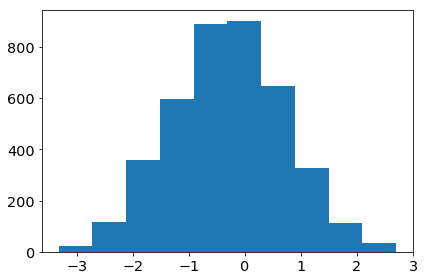

-0.3052831584785163
1.0066377184444064


In [13]:
plt.hist(y)
plt.show()
print(np.mean(y))
print(np.std(y))

In [14]:
clf_2 = RidgeCV
clf_args = dict(alphas=np.logspace(-4,2,7), normalize=True)
#clf_2 = Lasso
#clf_args = dict(alpha=1e-3)
#clf_2 = LinearRegression
#clf_args = dict()

#nl = lambda x: np.maximum(x, np.zeros(x.shape)) # relu
nl = lambda x: np.hstack((np.cos(x), np.sin(x)))
m = 1200
biregular = False

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

#Ks = [1, 2, 3, 4, 5, 8, 20, 40, d]
Ks = [1, 2, 3, 4, 8, d]
for K in Ks:
    print(str(m) + "-width layer")
    print(str(K) + "-sparse layer")
    clf = SparseRFRegressor(width=m, W_scale=1., clf=clf_2, nonlinearity=nl, deg=K, 
                            biregular=biregular, clf_args=clf_args)
    clf.fit(X_train, y_train)
    score_train = clf.score(X_train, y_train)
    score_test = clf.score(X_test, y_test)
    err_train = mse(clf.predict(X_train), y_train)
    err_test = mse(clf.predict(X_test), y_test)
    alpha = clf.clf.alpha_
    print("training: %f, testing: %f" % (score_train, score_test))
    print("error training: %f, testing: %f" % (err_train, err_test))
    print("alpha: %f" % alpha)

1200-width layer
1-sparse layer
training: 0.996080, testing: 0.996104
error training: 0.003957, testing: 0.004005
alpha: 0.010000
1200-width layer
2-sparse layer
training: 0.997206, testing: 0.997095
error training: 0.002820, testing: 0.002987
alpha: 0.010000
1200-width layer
3-sparse layer
training: 0.997585, testing: 0.997102
error training: 0.002437, testing: 0.002979
alpha: 0.001000
1200-width layer
4-sparse layer
training: 0.997273, testing: 0.997072
error training: 0.002753, testing: 0.003010
alpha: 0.010000
1200-width layer
8-sparse layer
training: 0.997307, testing: 0.997130
error training: 0.002718, testing: 0.002951
alpha: 0.010000
1200-width layer
16-sparse layer
training: 0.997349, testing: 0.997058
error training: 0.002675, testing: 0.003025
alpha: 0.010000


In [16]:
data = []
Ks =[1, 2, 3, 4, 10, d]
resample = 30

for K in Ks:
    for i in np.linspace(100,1000, 20):
    #for i in np.logspace(1.5, 3.5, 16):
        for sample in range(resample):
            i = int(i)
            print("Using " + str(i) + " samples")
            
            clf = SparseRFRegressor(width=m, W_scale=1., clf=clf_2, nonlinearity=nl, deg=K, 
                                    biregular=biregular, clf_args=clf_args)
            
            X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=i)
            assert X_train.shape[0] == i, "Wrong size training set"
            
            clf.fit(X_train, y_train)
            score_train = mse(clf.predict(X_train), y_train)
            score_test = mse(clf.predict(X_test), y_test)
            alpha = clf.clf.alpha_
            print("training: %f, testing: %f, alpha: %f" % (score_train, score_test, alpha))
            data.append({'deg': K, 'n_train': i, "err_train": score_train, "err_test": score_test,
                        'alpha': alpha})

data = pd.DataFrame(data)

Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002423, testing: 0.005818, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001148, testing: 0.006014, alpha: 0.010000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001595, testing: 0.005655, alpha: 0.010000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002829, testing: 0.006114, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002058, testing: 0.005948, alpha: 0.100000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002499, testing: 0.005972, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001790, testing: 0.005627, alpha: 0.100000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002183, testing: 0.007679, alpha: 0.010000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004345, testing: 0.006562, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002403, testing: 0.005693, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002693, testing: 0.006265, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002010, testing: 0.005620, alpha: 0.100000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.005392, testing: 0.005997, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002377, testing: 0.006550, alpha: 0.100000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002306, testing: 0.006612, alpha: 0.100000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002796, testing: 0.006150, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002902, testing: 0.005953, alpha: 0.100000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003221, testing: 0.006314, alpha: 0.100000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002322, testing: 0.005354, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002499, testing: 0.005543, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003068, testing: 0.005872, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003952, testing: 0.006355, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003619, testing: 0.005483, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002153, testing: 0.006201, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002300, testing: 0.005244, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004465, testing: 0.006391, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003190, testing: 0.006569, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001741, testing: 0.005768, alpha: 0.100000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001916, testing: 0.006095, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001767, testing: 0.006789, alpha: 0.100000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002813, testing: 0.005795, alpha: 0.010000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002720, testing: 0.005197, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003249, testing: 0.005143, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004824, testing: 0.005399, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001947, testing: 0.005401, alpha: 0.010000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003256, testing: 0.004773, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002621, testing: 0.004808, alpha: 0.100000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002557, testing: 0.004912, alpha: 0.100000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003337, testing: 0.005248, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003182, testing: 0.005034, alpha: 0.100000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003542, testing: 0.005176, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003568, testing: 0.005139, alpha: 0.100000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002998, testing: 0.005374, alpha: 0.100000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002463, testing: 0.005733, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.005167, testing: 0.005359, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002997, testing: 0.005394, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004225, testing: 0.006353, alpha: 0.100000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002931, testing: 0.005002, alpha: 0.100000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003395, testing: 0.005073, alpha: 0.100000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003691, testing: 0.005341, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003020, testing: 0.005408, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003708, testing: 0.004842, alpha: 0.100000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002643, testing: 0.005324, alpha: 0.100000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003860, testing: 0.005241, alpha: 0.100000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003134, testing: 0.005237, alpha: 0.100000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003087, testing: 0.005738, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003760, testing: 0.005200, alpha: 0.100000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002977, testing: 0.005376, alpha: 0.100000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003786, testing: 0.005335, alpha: 0.100000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002675, testing: 0.004896, alpha: 0.100000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003061, testing: 0.004951, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002722, testing: 0.004711, alpha: 0.100000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002724, testing: 0.004896, alpha: 0.100000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003741, testing: 0.004747, alpha: 0.100000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003711, testing: 0.004748, alpha: 0.100000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003884, testing: 0.005416, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004416, testing: 0.004833, alpha: 0.100000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002022, testing: 0.004716, alpha: 0.100000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003738, testing: 0.005076, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003432, testing: 0.004516, alpha: 0.100000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002747, testing: 0.004869, alpha: 0.100000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002579, testing: 0.004721, alpha: 0.100000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003893, testing: 0.005040, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002338, testing: 0.004788, alpha: 0.100000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002588, testing: 0.005035, alpha: 0.100000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002307, testing: 0.004715, alpha: 0.100000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003323, testing: 0.005108, alpha: 0.100000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002898, testing: 0.004965, alpha: 0.100000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003434, testing: 0.004871, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002792, testing: 0.005136, alpha: 0.100000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003250, testing: 0.005205, alpha: 0.100000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003044, testing: 0.004816, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003134, testing: 0.005270, alpha: 0.100000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002400, testing: 0.005009, alpha: 0.010000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002857, testing: 0.005095, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003349, testing: 0.005016, alpha: 0.100000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002668, testing: 0.004809, alpha: 0.100000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002722, testing: 0.005372, alpha: 0.100000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002819, testing: 0.005172, alpha: 0.100000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003844, testing: 0.004643, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002941, testing: 0.004463, alpha: 0.100000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004796, testing: 0.004959, alpha: 0.100000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002987, testing: 0.004678, alpha: 0.100000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003032, testing: 0.004588, alpha: 0.100000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003620, testing: 0.005159, alpha: 0.100000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003656, testing: 0.004679, alpha: 0.100000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004038, testing: 0.004538, alpha: 0.100000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004055, testing: 0.004781, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004219, testing: 0.004956, alpha: 0.100000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004179, testing: 0.004537, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002590, testing: 0.004777, alpha: 0.010000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003320, testing: 0.004763, alpha: 0.100000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003653, testing: 0.004479, alpha: 0.100000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003171, testing: 0.004703, alpha: 0.010000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004592, testing: 0.005291, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003187, testing: 0.005162, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003302, testing: 0.004519, alpha: 0.100000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003857, testing: 0.005331, alpha: 0.010000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004186, testing: 0.004589, alpha: 0.100000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003332, testing: 0.004479, alpha: 0.100000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003995, testing: 0.005357, alpha: 0.100000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003295, testing: 0.004904, alpha: 0.100000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003385, testing: 0.004431, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003951, testing: 0.004658, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003466, testing: 0.004737, alpha: 0.100000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003817, testing: 0.004847, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002525, testing: 0.004678, alpha: 0.100000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003781, testing: 0.004580, alpha: 0.100000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002439, testing: 0.004842, alpha: 0.100000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003762, testing: 0.005034, alpha: 0.100000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003188, testing: 0.004705, alpha: 0.100000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003906, testing: 0.004600, alpha: 0.100000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003609, testing: 0.004464, alpha: 0.010000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003306, testing: 0.004736, alpha: 0.010000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003807, testing: 0.004427, alpha: 0.100000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003303, testing: 0.004470, alpha: 0.100000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004137, testing: 0.004636, alpha: 0.100000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003690, testing: 0.004415, alpha: 0.100000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002815, testing: 0.004741, alpha: 0.100000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004114, testing: 0.004479, alpha: 0.100000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003353, testing: 0.004593, alpha: 0.100000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003994, testing: 0.004770, alpha: 0.010000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003459, testing: 0.004437, alpha: 0.100000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002925, testing: 0.004635, alpha: 0.100000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004190, testing: 0.004925, alpha: 0.100000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003548, testing: 0.004488, alpha: 0.100000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003055, testing: 0.004702, alpha: 0.100000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003681, testing: 0.004544, alpha: 0.100000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002534, testing: 0.004853, alpha: 0.010000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003234, testing: 0.004576, alpha: 0.100000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003498, testing: 0.004652, alpha: 0.100000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003165, testing: 0.004544, alpha: 0.100000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003316, testing: 0.004559, alpha: 0.100000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002734, testing: 0.004920, alpha: 0.100000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004078, testing: 0.004593, alpha: 0.100000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003101, testing: 0.004546, alpha: 0.100000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003040, testing: 0.004628, alpha: 0.100000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003053, testing: 0.004386, alpha: 0.100000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003096, testing: 0.004905, alpha: 0.100000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003174, testing: 0.004573, alpha: 0.100000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002952, testing: 0.004762, alpha: 0.100000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003510, testing: 0.004424, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003127, testing: 0.004840, alpha: 0.010000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002938, testing: 0.004603, alpha: 0.100000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003743, testing: 0.004459, alpha: 0.100000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003174, testing: 0.004537, alpha: 0.100000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004110, testing: 0.004376, alpha: 0.100000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003745, testing: 0.004328, alpha: 0.100000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003323, testing: 0.004705, alpha: 0.100000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003049, testing: 0.004673, alpha: 0.010000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003226, testing: 0.004537, alpha: 0.100000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003736, testing: 0.004583, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003342, testing: 0.004472, alpha: 0.100000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003704, testing: 0.004388, alpha: 0.100000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002892, testing: 0.004844, alpha: 0.010000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003808, testing: 0.004714, alpha: 0.010000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003439, testing: 0.004707, alpha: 0.100000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003091, testing: 0.004536, alpha: 0.100000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003402, testing: 0.004600, alpha: 0.010000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003869, testing: 0.004419, alpha: 0.100000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003053, testing: 0.004535, alpha: 0.010000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003030, testing: 0.004725, alpha: 0.100000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003495, testing: 0.004430, alpha: 0.100000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003555, testing: 0.004377, alpha: 0.100000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003056, testing: 0.004666, alpha: 0.100000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003700, testing: 0.004380, alpha: 0.100000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002878, testing: 0.004477, alpha: 0.100000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003037, testing: 0.004547, alpha: 0.100000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002620, testing: 0.004520, alpha: 0.010000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003623, testing: 0.004559, alpha: 0.100000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003657, testing: 0.004515, alpha: 0.100000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003568, testing: 0.004364, alpha: 0.100000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003288, testing: 0.004555, alpha: 0.100000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004204, testing: 0.004320, alpha: 0.100000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003898, testing: 0.004568, alpha: 0.100000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004129, testing: 0.004646, alpha: 0.100000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003342, testing: 0.004551, alpha: 0.100000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004152, testing: 0.004535, alpha: 0.100000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003118, testing: 0.004618, alpha: 0.100000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002741, testing: 0.004666, alpha: 0.100000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003640, testing: 0.004530, alpha: 0.100000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003203, testing: 0.004448, alpha: 0.100000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003417, testing: 0.004377, alpha: 0.100000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004004, testing: 0.004390, alpha: 0.100000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003775, testing: 0.004429, alpha: 0.100000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003029, testing: 0.004569, alpha: 0.100000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004036, testing: 0.004401, alpha: 0.100000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003394, testing: 0.004441, alpha: 0.100000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003637, testing: 0.004454, alpha: 0.100000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003520, testing: 0.004400, alpha: 0.010000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003818, testing: 0.004509, alpha: 0.100000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003191, testing: 0.004514, alpha: 0.100000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003532, testing: 0.004265, alpha: 0.100000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003326, testing: 0.004439, alpha: 0.100000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004403, testing: 0.004535, alpha: 0.100000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003734, testing: 0.004490, alpha: 0.010000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003892, testing: 0.004471, alpha: 0.100000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003484, testing: 0.004660, alpha: 0.100000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003879, testing: 0.004267, alpha: 0.100000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003239, testing: 0.004448, alpha: 0.100000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003891, testing: 0.004411, alpha: 0.100000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003907, testing: 0.004427, alpha: 0.100000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003171, testing: 0.004449, alpha: 0.100000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003500, testing: 0.004384, alpha: 0.100000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004002, testing: 0.004497, alpha: 0.100000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003154, testing: 0.004510, alpha: 0.010000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003285, testing: 0.004425, alpha: 0.100000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003528, testing: 0.004341, alpha: 0.100000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004026, testing: 0.004606, alpha: 0.010000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003548, testing: 0.004367, alpha: 0.100000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002924, testing: 0.004343, alpha: 0.100000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003003, testing: 0.004443, alpha: 0.100000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003606, testing: 0.004297, alpha: 0.100000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003822, testing: 0.004388, alpha: 0.100000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003947, testing: 0.004339, alpha: 0.100000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004239, testing: 0.004479, alpha: 0.010000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003670, testing: 0.004418, alpha: 0.100000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003499, testing: 0.004401, alpha: 0.100000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003156, testing: 0.004581, alpha: 0.100000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003120, testing: 0.004373, alpha: 0.100000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004087, testing: 0.004369, alpha: 0.100000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002928, testing: 0.004427, alpha: 0.100000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002932, testing: 0.004501, alpha: 0.010000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003621, testing: 0.004404, alpha: 0.100000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003221, testing: 0.004361, alpha: 0.100000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002888, testing: 0.004547, alpha: 0.100000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003925, testing: 0.004467, alpha: 0.100000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004369, testing: 0.004470, alpha: 0.100000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004260, testing: 0.004430, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004091, testing: 0.004425, alpha: 0.100000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003815, testing: 0.004329, alpha: 0.100000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003136, testing: 0.004597, alpha: 0.100000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004282, testing: 0.004276, alpha: 0.100000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003851, testing: 0.004465, alpha: 0.100000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003925, testing: 0.004382, alpha: 0.100000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003147, testing: 0.004388, alpha: 0.100000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003528, testing: 0.004328, alpha: 0.010000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003294, testing: 0.004331, alpha: 0.100000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003939, testing: 0.004506, alpha: 0.100000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003865, testing: 0.004320, alpha: 0.100000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004024, testing: 0.004302, alpha: 0.100000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003965, testing: 0.004301, alpha: 0.010000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003668, testing: 0.004343, alpha: 0.100000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003436, testing: 0.004485, alpha: 0.010000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003553, testing: 0.004396, alpha: 0.100000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003450, testing: 0.004439, alpha: 0.100000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003491, testing: 0.004471, alpha: 0.100000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003739, testing: 0.004375, alpha: 0.100000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003306, testing: 0.004501, alpha: 0.100000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003585, testing: 0.004558, alpha: 0.010000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003210, testing: 0.004450, alpha: 0.100000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003552, testing: 0.004356, alpha: 0.010000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003440, testing: 0.004429, alpha: 0.100000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004409, testing: 0.004373, alpha: 0.100000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004339, testing: 0.004420, alpha: 0.100000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003620, testing: 0.004291, alpha: 0.100000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003658, testing: 0.004333, alpha: 0.100000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003813, testing: 0.004240, alpha: 0.100000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003926, testing: 0.004330, alpha: 0.100000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004401, testing: 0.004315, alpha: 0.010000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002976, testing: 0.004474, alpha: 0.100000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003985, testing: 0.004490, alpha: 0.010000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003312, testing: 0.004436, alpha: 0.010000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003312, testing: 0.004554, alpha: 0.100000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003818, testing: 0.004276, alpha: 0.100000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003685, testing: 0.004331, alpha: 0.100000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004292, testing: 0.004262, alpha: 0.100000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003286, testing: 0.004346, alpha: 0.100000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004074, testing: 0.004200, alpha: 0.100000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003713, testing: 0.004499, alpha: 0.100000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004184, testing: 0.004163, alpha: 0.100000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003859, testing: 0.004322, alpha: 0.100000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003837, testing: 0.004303, alpha: 0.100000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003942, testing: 0.004300, alpha: 0.100000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003557, testing: 0.004353, alpha: 0.010000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004154, testing: 0.004254, alpha: 0.100000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004075, testing: 0.004178, alpha: 0.100000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003657, testing: 0.004373, alpha: 0.100000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003698, testing: 0.004333, alpha: 0.010000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003186, testing: 0.004454, alpha: 0.010000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003711, testing: 0.004359, alpha: 0.100000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003964, testing: 0.004215, alpha: 0.100000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003480, testing: 0.004394, alpha: 0.100000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003444, testing: 0.004369, alpha: 0.100000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003992, testing: 0.004269, alpha: 0.100000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003687, testing: 0.004267, alpha: 0.100000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003440, testing: 0.004632, alpha: 0.001000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003375, testing: 0.004407, alpha: 0.100000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003094, testing: 0.004451, alpha: 0.100000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003581, testing: 0.004418, alpha: 0.100000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004498, testing: 0.004144, alpha: 0.100000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004082, testing: 0.004234, alpha: 0.010000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004230, testing: 0.004230, alpha: 0.100000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003774, testing: 0.004289, alpha: 0.100000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004125, testing: 0.004253, alpha: 0.100000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003777, testing: 0.004259, alpha: 0.100000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003267, testing: 0.004314, alpha: 0.100000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003911, testing: 0.004283, alpha: 0.100000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003745, testing: 0.004350, alpha: 0.100000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004231, testing: 0.004188, alpha: 0.100000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003829, testing: 0.004306, alpha: 0.010000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003143, testing: 0.004355, alpha: 0.010000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003662, testing: 0.004331, alpha: 0.010000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003693, testing: 0.004280, alpha: 0.100000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003819, testing: 0.004200, alpha: 0.100000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004217, testing: 0.004252, alpha: 0.100000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003720, testing: 0.004327, alpha: 0.010000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003432, testing: 0.004292, alpha: 0.010000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003292, testing: 0.004337, alpha: 0.010000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003736, testing: 0.004419, alpha: 0.100000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003830, testing: 0.004389, alpha: 0.010000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003102, testing: 0.004601, alpha: 0.100000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004243, testing: 0.004424, alpha: 0.100000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004013, testing: 0.004302, alpha: 0.010000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003713, testing: 0.004331, alpha: 0.100000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003570, testing: 0.004308, alpha: 0.010000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003808, testing: 0.004385, alpha: 0.010000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003390, testing: 0.004358, alpha: 0.010000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003534, testing: 0.004387, alpha: 0.100000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004439, testing: 0.004385, alpha: 0.100000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003562, testing: 0.004263, alpha: 0.100000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003709, testing: 0.004311, alpha: 0.100000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003337, testing: 0.004360, alpha: 0.010000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003279, testing: 0.004562, alpha: 0.010000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003157, testing: 0.004292, alpha: 0.100000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004008, testing: 0.004207, alpha: 0.100000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003453, testing: 0.004244, alpha: 0.010000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003576, testing: 0.004348, alpha: 0.100000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003633, testing: 0.004360, alpha: 0.010000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004280, testing: 0.004239, alpha: 0.010000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003902, testing: 0.004209, alpha: 0.100000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003220, testing: 0.004381, alpha: 0.100000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003980, testing: 0.004164, alpha: 0.010000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003667, testing: 0.004186, alpha: 0.100000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003741, testing: 0.004240, alpha: 0.010000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004265, testing: 0.004301, alpha: 0.100000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004002, testing: 0.004249, alpha: 0.100000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003413, testing: 0.004352, alpha: 0.100000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004063, testing: 0.004254, alpha: 0.100000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003848, testing: 0.004385, alpha: 0.100000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003768, testing: 0.004493, alpha: 0.100000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004624, testing: 0.004220, alpha: 0.100000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003701, testing: 0.004249, alpha: 0.100000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004418, testing: 0.004189, alpha: 0.100000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003761, testing: 0.004292, alpha: 0.010000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004265, testing: 0.004221, alpha: 0.100000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004011, testing: 0.004287, alpha: 0.100000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003681, testing: 0.004273, alpha: 0.100000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003528, testing: 0.004289, alpha: 0.010000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003826, testing: 0.004252, alpha: 0.100000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004182, testing: 0.004174, alpha: 0.100000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003446, testing: 0.004315, alpha: 0.100000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003603, testing: 0.004303, alpha: 0.010000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003793, testing: 0.004276, alpha: 0.100000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003280, testing: 0.004333, alpha: 0.010000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003513, testing: 0.004294, alpha: 0.010000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003865, testing: 0.004225, alpha: 0.010000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003617, testing: 0.004326, alpha: 0.010000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004037, testing: 0.004225, alpha: 0.100000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003624, testing: 0.004322, alpha: 0.100000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004040, testing: 0.004202, alpha: 0.100000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003591, testing: 0.004256, alpha: 0.010000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003733, testing: 0.004242, alpha: 0.100000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003740, testing: 0.004238, alpha: 0.010000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003618, testing: 0.004375, alpha: 0.100000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003776, testing: 0.004540, alpha: 0.010000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004869, testing: 0.004116, alpha: 0.100000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003477, testing: 0.004372, alpha: 0.010000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003699, testing: 0.004274, alpha: 0.100000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003469, testing: 0.004365, alpha: 0.100000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003614, testing: 0.004245, alpha: 0.010000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003697, testing: 0.004265, alpha: 0.010000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003498, testing: 0.004321, alpha: 0.010000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003435, testing: 0.004304, alpha: 0.010000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003439, testing: 0.004313, alpha: 0.010000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003417, testing: 0.004378, alpha: 0.010000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003973, testing: 0.004156, alpha: 0.100000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003565, testing: 0.004261, alpha: 0.010000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003374, testing: 0.004343, alpha: 0.100000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003490, testing: 0.004273, alpha: 0.100000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003869, testing: 0.004162, alpha: 0.010000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003846, testing: 0.004275, alpha: 0.100000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004212, testing: 0.004206, alpha: 0.100000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003965, testing: 0.004203, alpha: 0.100000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003426, testing: 0.004315, alpha: 0.010000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003784, testing: 0.004258, alpha: 0.100000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003822, testing: 0.004335, alpha: 0.100000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004218, testing: 0.004247, alpha: 0.100000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003500, testing: 0.004270, alpha: 0.010000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003653, testing: 0.004258, alpha: 0.010000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003551, testing: 0.004266, alpha: 0.010000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003930, testing: 0.004176, alpha: 0.100000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003852, testing: 0.004319, alpha: 0.100000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003576, testing: 0.004373, alpha: 0.100000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003914, testing: 0.004149, alpha: 0.010000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003882, testing: 0.004212, alpha: 0.010000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003672, testing: 0.004305, alpha: 0.100000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003429, testing: 0.004410, alpha: 0.100000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003889, testing: 0.004243, alpha: 0.100000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003731, testing: 0.004225, alpha: 0.100000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003698, testing: 0.004234, alpha: 0.100000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003683, testing: 0.004307, alpha: 0.100000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003351, testing: 0.004379, alpha: 0.100000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004077, testing: 0.004193, alpha: 0.100000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003461, testing: 0.004281, alpha: 0.010000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004158, testing: 0.004151, alpha: 0.100000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003723, testing: 0.004240, alpha: 0.100000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003745, testing: 0.004297, alpha: 0.100000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004228, testing: 0.004145, alpha: 0.010000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003978, testing: 0.004193, alpha: 0.010000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003661, testing: 0.004374, alpha: 0.010000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003502, testing: 0.004240, alpha: 0.010000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004026, testing: 0.004109, alpha: 0.100000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004189, testing: 0.004118, alpha: 0.010000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004009, testing: 0.004233, alpha: 0.100000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003866, testing: 0.004229, alpha: 0.010000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003219, testing: 0.004293, alpha: 0.010000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003716, testing: 0.004209, alpha: 0.010000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003731, testing: 0.004242, alpha: 0.100000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003966, testing: 0.004247, alpha: 0.100000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003715, testing: 0.004312, alpha: 0.100000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004034, testing: 0.004212, alpha: 0.100000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003894, testing: 0.004187, alpha: 0.100000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003413, testing: 0.004322, alpha: 0.010000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004147, testing: 0.004231, alpha: 0.100000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004490, testing: 0.004078, alpha: 0.010000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003528, testing: 0.004330, alpha: 0.010000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003686, testing: 0.004270, alpha: 0.100000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004004, testing: 0.004225, alpha: 0.100000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004653, testing: 0.003994, alpha: 0.100000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003917, testing: 0.004240, alpha: 0.100000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003534, testing: 0.004289, alpha: 0.010000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003563, testing: 0.004371, alpha: 0.010000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003774, testing: 0.004242, alpha: 0.010000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004090, testing: 0.004197, alpha: 0.010000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003763, testing: 0.004278, alpha: 0.100000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004208, testing: 0.004110, alpha: 0.010000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003390, testing: 0.004244, alpha: 0.010000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003677, testing: 0.004272, alpha: 0.010000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003331, testing: 0.004349, alpha: 0.010000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003552, testing: 0.004282, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003586, testing: 0.004423, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003569, testing: 0.004277, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003967, testing: 0.004166, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004107, testing: 0.004278, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003885, testing: 0.004297, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004316, testing: 0.004085, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003546, testing: 0.004335, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003865, testing: 0.004281, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004070, testing: 0.004130, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003703, testing: 0.004287, alpha: 0.010000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003957, testing: 0.004166, alpha: 0.010000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003958, testing: 0.004160, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003561, testing: 0.004289, alpha: 0.010000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004102, testing: 0.004180, alpha: 0.010000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004479, testing: 0.004093, alpha: 0.010000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003820, testing: 0.004182, alpha: 0.010000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003631, testing: 0.004307, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003657, testing: 0.004229, alpha: 0.010000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004121, testing: 0.004190, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004022, testing: 0.004235, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003933, testing: 0.004225, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004209, testing: 0.004166, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004026, testing: 0.004120, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004041, testing: 0.004154, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004133, testing: 0.004109, alpha: 0.010000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003661, testing: 0.004156, alpha: 0.010000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003783, testing: 0.004248, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003805, testing: 0.004309, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003192, testing: 0.004411, alpha: 0.010000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003655, testing: 0.004337, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003743, testing: 0.004230, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004212, testing: 0.004099, alpha: 0.010000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003677, testing: 0.004277, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003822, testing: 0.004207, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004126, testing: 0.004152, alpha: 0.010000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003375, testing: 0.004322, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004006, testing: 0.004215, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003870, testing: 0.004159, alpha: 0.010000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003700, testing: 0.004279, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004400, testing: 0.004193, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004366, testing: 0.004092, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003988, testing: 0.004236, alpha: 0.010000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003579, testing: 0.004300, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003903, testing: 0.004198, alpha: 0.010000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003455, testing: 0.004312, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003663, testing: 0.004238, alpha: 0.010000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004040, testing: 0.004222, alpha: 0.010000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003642, testing: 0.004270, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003574, testing: 0.004276, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003897, testing: 0.004213, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003185, testing: 0.004350, alpha: 0.010000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003438, testing: 0.004237, alpha: 0.010000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004632, testing: 0.004160, alpha: 0.010000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003564, testing: 0.004355, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003655, testing: 0.004217, alpha: 0.010000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004525, testing: 0.004084, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003911, testing: 0.004200, alpha: 0.010000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004018, testing: 0.004097, alpha: 0.010000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004099, testing: 0.004185, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003703, testing: 0.004188, alpha: 0.010000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003544, testing: 0.004241, alpha: 0.010000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003795, testing: 0.004227, alpha: 0.010000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003687, testing: 0.004293, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003774, testing: 0.004167, alpha: 0.010000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003578, testing: 0.004307, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003711, testing: 0.004267, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003840, testing: 0.004165, alpha: 0.010000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003976, testing: 0.004200, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003685, testing: 0.004247, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003477, testing: 0.004340, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003948, testing: 0.004183, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004031, testing: 0.004233, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003690, testing: 0.004194, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003715, testing: 0.004342, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003426, testing: 0.004293, alpha: 0.010000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004135, testing: 0.004108, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004018, testing: 0.004144, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003951, testing: 0.004154, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003682, testing: 0.004255, alpha: 0.010000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003440, testing: 0.004299, alpha: 0.010000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004211, testing: 0.004200, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003982, testing: 0.004130, alpha: 0.010000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003883, testing: 0.004165, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003749, testing: 0.004217, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003451, testing: 0.004297, alpha: 0.010000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003902, testing: 0.004198, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003303, testing: 0.004295, alpha: 0.010000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004056, testing: 0.004118, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003573, testing: 0.004306, alpha: 0.010000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003234, testing: 0.004360, alpha: 0.010000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003851, testing: 0.004158, alpha: 0.010000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003892, testing: 0.004127, alpha: 0.010000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003703, testing: 0.004272, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004133, testing: 0.004131, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003874, testing: 0.004173, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003629, testing: 0.004315, alpha: 0.010000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004252, testing: 0.004121, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003564, testing: 0.004361, alpha: 0.010000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004036, testing: 0.004145, alpha: 0.010000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003603, testing: 0.004316, alpha: 0.010000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004210, testing: 0.004101, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003713, testing: 0.004189, alpha: 0.010000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003583, testing: 0.004207, alpha: 0.010000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003424, testing: 0.004276, alpha: 0.010000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003807, testing: 0.004192, alpha: 0.010000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003661, testing: 0.004374, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004127, testing: 0.004125, alpha: 0.010000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003695, testing: 0.004236, alpha: 0.010000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003626, testing: 0.004321, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003635, testing: 0.004324, alpha: 0.010000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004212, testing: 0.004106, alpha: 0.010000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003451, testing: 0.004291, alpha: 0.010000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003520, testing: 0.004233, alpha: 0.010000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003753, testing: 0.004179, alpha: 0.010000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003996, testing: 0.004086, alpha: 0.010000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003884, testing: 0.004136, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003363, testing: 0.004279, alpha: 0.010000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003695, testing: 0.004333, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003974, testing: 0.004188, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003950, testing: 0.004131, alpha: 0.010000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003724, testing: 0.004212, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004054, testing: 0.004199, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003731, testing: 0.004196, alpha: 0.010000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004015, testing: 0.004086, alpha: 0.010000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003623, testing: 0.004286, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004215, testing: 0.004078, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003978, testing: 0.004131, alpha: 0.010000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003501, testing: 0.004380, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004013, testing: 0.004064, alpha: 0.010000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004019, testing: 0.004160, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003417, testing: 0.004347, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003735, testing: 0.004299, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003762, testing: 0.004188, alpha: 0.010000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003945, testing: 0.004160, alpha: 0.010000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003818, testing: 0.004160, alpha: 0.010000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003631, testing: 0.004230, alpha: 0.010000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003684, testing: 0.004273, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003868, testing: 0.004153, alpha: 0.010000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004097, testing: 0.004026, alpha: 0.010000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004042, testing: 0.004083, alpha: 0.010000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003533, testing: 0.004297, alpha: 0.010000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003296, testing: 0.004360, alpha: 0.010000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003737, testing: 0.004161, alpha: 0.010000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003793, testing: 0.004283, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003524, testing: 0.004336, alpha: 0.010000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.004350, testing: 0.004099, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003669, testing: 0.004334, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003739, testing: 0.004268, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003882, testing: 0.004253, alpha: 0.100000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000798, testing: 0.006159, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001070, testing: 0.006653, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000968, testing: 0.006109, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001135, testing: 0.006384, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001080, testing: 0.005663, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001281, testing: 0.006226, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000831, testing: 0.006534, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001003, testing: 0.005851, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000902, testing: 0.009503, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000983, testing: 0.006022, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000712, testing: 0.006521, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000798, testing: 0.006083, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000888, testing: 0.006275, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000766, testing: 0.005926, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001377, testing: 0.006023, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001280, testing: 0.008147, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001178, testing: 0.006282, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001137, testing: 0.005669, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000746, testing: 0.005530, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001046, testing: 0.006455, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001245, testing: 0.007794, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000924, testing: 0.005880, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000794, testing: 0.005722, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000963, testing: 0.007031, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001358, testing: 0.006219, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000603, testing: 0.005822, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000088, testing: 0.007424, alpha: 0.100000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001279, testing: 0.006061, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000983, testing: 0.006136, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000930, testing: 0.005181, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001402, testing: 0.004656, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001485, testing: 0.005692, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001559, testing: 0.004961, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001421, testing: 0.005383, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001977, testing: 0.006626, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001505, testing: 0.005063, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001224, testing: 0.006115, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001161, testing: 0.005239, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001379, testing: 0.005082, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001612, testing: 0.005670, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001275, testing: 0.005265, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001374, testing: 0.005371, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001381, testing: 0.006180, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001203, testing: 0.005436, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001181, testing: 0.005611, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001354, testing: 0.005205, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001048, testing: 0.006026, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001250, testing: 0.004944, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002089, testing: 0.004617, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002137, testing: 0.004688, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001485, testing: 0.005605, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001454, testing: 0.005088, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001794, testing: 0.006113, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001372, testing: 0.006181, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001466, testing: 0.006015, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001365, testing: 0.005443, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001611, testing: 0.005837, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001522, testing: 0.005854, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001155, testing: 0.005775, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001644, testing: 0.005883, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001728, testing: 0.005042, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001885, testing: 0.004730, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002337, testing: 0.005012, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001770, testing: 0.004699, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001634, testing: 0.005558, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001425, testing: 0.005552, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002053, testing: 0.004539, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001832, testing: 0.004806, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001541, testing: 0.005240, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002260, testing: 0.004815, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001691, testing: 0.005042, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001975, testing: 0.004999, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001898, testing: 0.004216, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001913, testing: 0.004636, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001849, testing: 0.004910, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001677, testing: 0.004742, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001551, testing: 0.005354, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001654, testing: 0.004777, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001614, testing: 0.004932, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002055, testing: 0.004341, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001968, testing: 0.004573, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001706, testing: 0.004978, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001694, testing: 0.005583, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002140, testing: 0.004981, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001883, testing: 0.004765, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001887, testing: 0.005009, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001795, testing: 0.004751, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002000, testing: 0.005220, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001960, testing: 0.004877, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001711, testing: 0.005184, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001998, testing: 0.004868, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002400, testing: 0.004238, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002587, testing: 0.004799, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001827, testing: 0.004711, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002288, testing: 0.004680, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002313, testing: 0.004527, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001790, testing: 0.004900, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001943, testing: 0.004689, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001753, testing: 0.004582, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002288, testing: 0.004581, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002341, testing: 0.004937, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002239, testing: 0.004849, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001587, testing: 0.004686, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002318, testing: 0.004824, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002226, testing: 0.004413, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002052, testing: 0.004203, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002247, testing: 0.004668, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002263, testing: 0.004885, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002351, testing: 0.004916, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002638, testing: 0.004815, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002505, testing: 0.004565, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001963, testing: 0.004980, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002199, testing: 0.004579, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002078, testing: 0.004477, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002509, testing: 0.004735, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002207, testing: 0.004451, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002148, testing: 0.004713, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002451, testing: 0.004118, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002140, testing: 0.004679, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002106, testing: 0.004846, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002384, testing: 0.004532, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002279, testing: 0.004540, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002249, testing: 0.004465, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002511, testing: 0.004499, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002364, testing: 0.004217, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002633, testing: 0.004029, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002620, testing: 0.004407, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001980, testing: 0.004722, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002161, testing: 0.004788, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002668, testing: 0.004164, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002386, testing: 0.004193, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002547, testing: 0.004287, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002490, testing: 0.004714, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002492, testing: 0.004269, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002609, testing: 0.004040, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002166, testing: 0.004708, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001944, testing: 0.004513, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002570, testing: 0.004175, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002239, testing: 0.004543, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002059, testing: 0.004764, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002224, testing: 0.004238, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002230, testing: 0.004307, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002193, testing: 0.004755, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002311, testing: 0.004650, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002501, testing: 0.005005, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002148, testing: 0.004097, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002806, testing: 0.004355, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002153, testing: 0.004741, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002104, testing: 0.004065, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002407, testing: 0.004396, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001982, testing: 0.004842, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002349, testing: 0.003848, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002537, testing: 0.004271, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002419, testing: 0.004183, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002400, testing: 0.004241, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002421, testing: 0.003943, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002909, testing: 0.004485, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002768, testing: 0.004106, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002556, testing: 0.004080, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002568, testing: 0.004161, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002232, testing: 0.004304, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002233, testing: 0.004250, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002453, testing: 0.004561, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002403, testing: 0.004481, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002484, testing: 0.004015, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002388, testing: 0.004462, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002325, testing: 0.004232, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002384, testing: 0.004590, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002424, testing: 0.004532, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002802, testing: 0.003908, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002672, testing: 0.004315, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001373, testing: 0.004288, alpha: 0.100000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002113, testing: 0.004486, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002044, testing: 0.004511, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002352, testing: 0.004469, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002549, testing: 0.004209, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002386, testing: 0.004264, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002207, testing: 0.004540, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002473, testing: 0.004294, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002524, testing: 0.004966, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002239, testing: 0.004496, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002612, testing: 0.004198, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002766, testing: 0.004052, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002929, testing: 0.004049, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002409, testing: 0.004223, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002526, testing: 0.004130, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002324, testing: 0.004090, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002475, testing: 0.004178, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002429, testing: 0.004340, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002681, testing: 0.004123, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002697, testing: 0.004267, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002467, testing: 0.003987, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002590, testing: 0.004060, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002673, testing: 0.004137, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002918, testing: 0.004113, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002529, testing: 0.003967, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002454, testing: 0.004203, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002520, testing: 0.004069, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002365, testing: 0.004175, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002320, testing: 0.004278, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001812, testing: 0.004414, alpha: 0.100000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003107, testing: 0.004159, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002413, testing: 0.004073, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002469, testing: 0.004302, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002223, testing: 0.004160, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002920, testing: 0.004266, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002406, testing: 0.004312, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002675, testing: 0.004077, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002337, testing: 0.004180, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002328, testing: 0.004597, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002727, testing: 0.004120, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002789, testing: 0.004244, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002829, testing: 0.004251, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002596, testing: 0.004045, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002809, testing: 0.004650, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001921, testing: 0.004493, alpha: 0.100000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003212, testing: 0.004238, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002992, testing: 0.004106, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001858, testing: 0.004693, alpha: 0.100000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002318, testing: 0.004110, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002652, testing: 0.004089, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002290, testing: 0.004196, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002565, testing: 0.004182, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002685, testing: 0.004175, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002655, testing: 0.004442, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002652, testing: 0.003952, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002600, testing: 0.004210, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002560, testing: 0.004006, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001981, testing: 0.004027, alpha: 0.100000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002655, testing: 0.004226, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002528, testing: 0.004054, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003056, testing: 0.003894, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002642, testing: 0.004345, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002913, testing: 0.004430, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001986, testing: 0.004550, alpha: 0.100000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001913, testing: 0.004526, alpha: 0.100000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001946, testing: 0.004372, alpha: 0.100000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002647, testing: 0.003890, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003025, testing: 0.004030, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002190, testing: 0.004300, alpha: 0.100000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002819, testing: 0.003961, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002646, testing: 0.004189, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001946, testing: 0.004302, alpha: 0.100000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002565, testing: 0.004048, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002183, testing: 0.004077, alpha: 0.100000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001893, testing: 0.004038, alpha: 0.100000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002107, testing: 0.004235, alpha: 0.100000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001885, testing: 0.004212, alpha: 0.100000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002668, testing: 0.004312, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003009, testing: 0.003891, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001970, testing: 0.004054, alpha: 0.100000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003298, testing: 0.003926, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002652, testing: 0.003981, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002647, testing: 0.003973, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002950, testing: 0.003929, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002070, testing: 0.004354, alpha: 0.100000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002840, testing: 0.004006, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002525, testing: 0.003933, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002101, testing: 0.004261, alpha: 0.100000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002426, testing: 0.004081, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002479, testing: 0.004126, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002763, testing: 0.003920, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002829, testing: 0.004059, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002335, testing: 0.004279, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002802, testing: 0.004048, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002803, testing: 0.004320, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002646, testing: 0.004254, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003060, testing: 0.004029, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002643, testing: 0.003999, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002241, testing: 0.004443, alpha: 0.100000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002637, testing: 0.004235, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002454, testing: 0.004416, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001919, testing: 0.004116, alpha: 0.100000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002198, testing: 0.003946, alpha: 0.100000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002518, testing: 0.004161, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002762, testing: 0.004070, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002267, testing: 0.004139, alpha: 0.100000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002791, testing: 0.003872, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002782, testing: 0.003856, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002075, testing: 0.004193, alpha: 0.100000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001979, testing: 0.004000, alpha: 0.100000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002695, testing: 0.003923, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002892, testing: 0.004465, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003070, testing: 0.004150, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002928, testing: 0.004157, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002984, testing: 0.003922, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001946, testing: 0.004108, alpha: 0.100000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003190, testing: 0.004082, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002944, testing: 0.003994, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002428, testing: 0.004153, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001806, testing: 0.004632, alpha: 0.010000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002359, testing: 0.004196, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002741, testing: 0.004457, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003296, testing: 0.003795, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001993, testing: 0.003802, alpha: 0.100000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002714, testing: 0.004059, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002614, testing: 0.004213, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002770, testing: 0.004035, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002748, testing: 0.004056, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002590, testing: 0.004121, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002868, testing: 0.004012, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002112, testing: 0.003839, alpha: 0.100000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003041, testing: 0.003729, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002656, testing: 0.003885, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003303, testing: 0.003869, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002762, testing: 0.004052, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002520, testing: 0.003908, alpha: 0.100000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002207, testing: 0.003854, alpha: 0.100000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002626, testing: 0.004139, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002758, testing: 0.003810, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002364, testing: 0.004015, alpha: 0.100000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002010, testing: 0.003952, alpha: 0.100000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002069, testing: 0.003908, alpha: 0.100000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002134, testing: 0.004417, alpha: 0.100000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002125, testing: 0.004179, alpha: 0.100000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002214, testing: 0.003927, alpha: 0.100000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002718, testing: 0.003764, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003049, testing: 0.003869, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002164, testing: 0.004101, alpha: 0.100000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002866, testing: 0.003995, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002444, testing: 0.004121, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001930, testing: 0.004069, alpha: 0.100000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002951, testing: 0.003951, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003026, testing: 0.003835, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002515, testing: 0.004165, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002917, testing: 0.004044, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002185, testing: 0.004208, alpha: 0.100000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002068, testing: 0.004200, alpha: 0.100000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002997, testing: 0.004003, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003029, testing: 0.003888, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002248, testing: 0.003816, alpha: 0.100000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002826, testing: 0.004196, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002642, testing: 0.004086, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002688, testing: 0.004310, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002216, testing: 0.003926, alpha: 0.100000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002662, testing: 0.004030, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002256, testing: 0.003726, alpha: 0.100000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002464, testing: 0.003895, alpha: 0.100000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002158, testing: 0.004048, alpha: 0.100000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002173, testing: 0.003972, alpha: 0.100000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002954, testing: 0.004068, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002113, testing: 0.003744, alpha: 0.100000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003326, testing: 0.003920, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002749, testing: 0.003915, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002339, testing: 0.003712, alpha: 0.100000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002373, testing: 0.004039, alpha: 0.100000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002361, testing: 0.003776, alpha: 0.100000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002285, testing: 0.004130, alpha: 0.100000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002012, testing: 0.004136, alpha: 0.100000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002334, testing: 0.004080, alpha: 0.100000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002695, testing: 0.003809, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002374, testing: 0.003884, alpha: 0.100000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002824, testing: 0.003766, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002331, testing: 0.003674, alpha: 0.100000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002972, testing: 0.003919, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002383, testing: 0.003752, alpha: 0.100000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002457, testing: 0.003845, alpha: 0.100000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002871, testing: 0.003884, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002383, testing: 0.003765, alpha: 0.100000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002519, testing: 0.003807, alpha: 0.100000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002566, testing: 0.004090, alpha: 0.100000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002329, testing: 0.003725, alpha: 0.100000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002430, testing: 0.003825, alpha: 0.100000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002413, testing: 0.003787, alpha: 0.100000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002277, testing: 0.003766, alpha: 0.100000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002248, testing: 0.003873, alpha: 0.100000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002629, testing: 0.003805, alpha: 0.100000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002363, testing: 0.003986, alpha: 0.100000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002116, testing: 0.003788, alpha: 0.100000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001946, testing: 0.003810, alpha: 0.100000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002298, testing: 0.003839, alpha: 0.100000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003003, testing: 0.004052, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002226, testing: 0.003802, alpha: 0.100000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002290, testing: 0.003636, alpha: 0.100000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002109, testing: 0.003758, alpha: 0.100000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002562, testing: 0.003932, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002916, testing: 0.003882, alpha: 0.100000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002755, testing: 0.003760, alpha: 0.100000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002312, testing: 0.003592, alpha: 0.100000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002881, testing: 0.003718, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002382, testing: 0.003681, alpha: 0.100000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002360, testing: 0.003996, alpha: 0.100000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002371, testing: 0.003893, alpha: 0.100000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002219, testing: 0.003684, alpha: 0.100000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002493, testing: 0.003782, alpha: 0.100000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002346, testing: 0.003934, alpha: 0.100000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002383, testing: 0.003693, alpha: 0.100000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002878, testing: 0.003947, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002634, testing: 0.004110, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002617, testing: 0.003907, alpha: 0.100000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002371, testing: 0.003834, alpha: 0.100000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002362, testing: 0.003791, alpha: 0.100000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002340, testing: 0.003600, alpha: 0.100000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002341, testing: 0.003803, alpha: 0.100000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002515, testing: 0.003708, alpha: 0.100000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002423, testing: 0.003972, alpha: 0.100000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002439, testing: 0.003966, alpha: 0.100000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002364, testing: 0.003834, alpha: 0.100000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002649, testing: 0.003770, alpha: 0.100000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002594, testing: 0.003572, alpha: 0.100000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002117, testing: 0.003739, alpha: 0.100000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002565, testing: 0.003720, alpha: 0.100000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002313, testing: 0.003976, alpha: 0.100000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002339, testing: 0.003753, alpha: 0.100000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002471, testing: 0.003691, alpha: 0.100000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002409, testing: 0.003762, alpha: 0.100000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002561, testing: 0.003737, alpha: 0.100000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002266, testing: 0.003938, alpha: 0.100000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002320, testing: 0.003806, alpha: 0.100000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002177, testing: 0.003680, alpha: 0.100000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002509, testing: 0.003749, alpha: 0.100000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002600, testing: 0.003761, alpha: 0.100000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002067, testing: 0.003778, alpha: 0.100000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002892, testing: 0.003972, alpha: 1.000000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002264, testing: 0.003866, alpha: 0.100000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002373, testing: 0.003814, alpha: 0.100000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002193, testing: 0.003799, alpha: 0.100000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002404, testing: 0.003781, alpha: 0.100000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002461, testing: 0.003635, alpha: 0.100000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002537, testing: 0.003648, alpha: 0.100000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002454, testing: 0.003716, alpha: 0.100000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002322, testing: 0.003654, alpha: 0.100000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002562, testing: 0.003587, alpha: 0.100000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002396, testing: 0.003920, alpha: 0.100000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002249, testing: 0.003762, alpha: 0.100000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002485, testing: 0.003581, alpha: 0.100000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002318, testing: 0.003717, alpha: 0.100000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002378, testing: 0.003784, alpha: 0.100000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003248, testing: 0.003719, alpha: 1.000000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002526, testing: 0.003818, alpha: 0.100000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002387, testing: 0.003696, alpha: 0.100000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002614, testing: 0.003813, alpha: 0.100000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002690, testing: 0.003941, alpha: 1.000000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002513, testing: 0.003659, alpha: 0.100000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002261, testing: 0.004011, alpha: 0.100000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002763, testing: 0.003538, alpha: 0.100000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002442, testing: 0.003795, alpha: 0.100000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002367, testing: 0.003694, alpha: 0.100000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002439, testing: 0.003711, alpha: 0.100000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002617, testing: 0.003570, alpha: 0.100000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002601, testing: 0.003751, alpha: 0.100000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002405, testing: 0.003803, alpha: 0.100000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002394, testing: 0.003728, alpha: 0.100000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002498, testing: 0.003713, alpha: 0.100000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002501, testing: 0.003661, alpha: 0.100000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002454, testing: 0.003737, alpha: 0.100000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002486, testing: 0.004118, alpha: 1.000000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002402, testing: 0.003677, alpha: 0.100000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002285, testing: 0.003626, alpha: 0.100000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002576, testing: 0.003673, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002447, testing: 0.003716, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002451, testing: 0.003673, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002576, testing: 0.003548, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002814, testing: 0.003496, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002368, testing: 0.003638, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002366, testing: 0.003713, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002658, testing: 0.003607, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002555, testing: 0.003586, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002365, testing: 0.003647, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002453, testing: 0.003647, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002401, testing: 0.003660, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002460, testing: 0.003607, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002457, testing: 0.003835, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002519, testing: 0.003522, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002419, testing: 0.003823, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002135, testing: 0.003828, alpha: 0.010000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002553, testing: 0.003577, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002317, testing: 0.003671, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002637, testing: 0.003644, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002690, testing: 0.003698, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002386, testing: 0.003662, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002553, testing: 0.003676, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002565, testing: 0.003629, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002458, testing: 0.003671, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002583, testing: 0.003556, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002343, testing: 0.003665, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002431, testing: 0.003701, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002514, testing: 0.003642, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002524, testing: 0.003817, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002415, testing: 0.003529, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002434, testing: 0.003589, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002600, testing: 0.003574, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002529, testing: 0.003651, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002623, testing: 0.003650, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002397, testing: 0.003571, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002692, testing: 0.003592, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002631, testing: 0.003502, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002498, testing: 0.003719, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002429, testing: 0.003711, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002620, testing: 0.003780, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002680, testing: 0.003701, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002492, testing: 0.003585, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002373, testing: 0.003752, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002337, testing: 0.003707, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002493, testing: 0.003621, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002512, testing: 0.003693, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002409, testing: 0.003731, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002070, testing: 0.003822, alpha: 0.010000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002492, testing: 0.003608, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002496, testing: 0.003581, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002522, testing: 0.003743, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002604, testing: 0.003590, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002594, testing: 0.003642, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002629, testing: 0.003622, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002463, testing: 0.003797, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002209, testing: 0.003624, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002397, testing: 0.003583, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002444, testing: 0.003659, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002579, testing: 0.003586, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002609, testing: 0.003584, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002572, testing: 0.003626, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002559, testing: 0.003501, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002333, testing: 0.003726, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002471, testing: 0.003545, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002336, testing: 0.003789, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002467, testing: 0.003576, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002411, testing: 0.003614, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002602, testing: 0.003663, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002544, testing: 0.003552, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002304, testing: 0.003807, alpha: 0.010000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002592, testing: 0.003665, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002668, testing: 0.003686, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002567, testing: 0.003544, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002751, testing: 0.003424, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002544, testing: 0.003635, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002618, testing: 0.003768, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002280, testing: 0.003668, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002390, testing: 0.003619, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002364, testing: 0.003618, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002582, testing: 0.003515, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002258, testing: 0.003718, alpha: 0.010000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002538, testing: 0.003510, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002280, testing: 0.003603, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002480, testing: 0.003727, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002533, testing: 0.003696, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002362, testing: 0.003725, alpha: 0.010000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002423, testing: 0.003700, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002609, testing: 0.003396, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002732, testing: 0.003505, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002497, testing: 0.003640, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002377, testing: 0.003600, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002595, testing: 0.003592, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002947, testing: 0.003486, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002520, testing: 0.003532, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002747, testing: 0.003606, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002639, testing: 0.003574, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002447, testing: 0.003594, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002465, testing: 0.003669, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002454, testing: 0.003613, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002649, testing: 0.003582, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002415, testing: 0.003550, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002380, testing: 0.003602, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002612, testing: 0.003530, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002648, testing: 0.003470, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002420, testing: 0.003509, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002625, testing: 0.003534, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002463, testing: 0.003711, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002747, testing: 0.003566, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002432, testing: 0.003671, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002599, testing: 0.003531, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002080, testing: 0.003703, alpha: 0.010000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002521, testing: 0.003542, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002622, testing: 0.003650, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002513, testing: 0.003659, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002555, testing: 0.003569, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002531, testing: 0.003509, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002596, testing: 0.003508, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002651, testing: 0.003449, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002186, testing: 0.003784, alpha: 0.010000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002534, testing: 0.003649, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002755, testing: 0.003555, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002681, testing: 0.003604, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002833, testing: 0.003435, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002471, testing: 0.003672, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002660, testing: 0.003508, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002579, testing: 0.003597, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002573, testing: 0.003750, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002443, testing: 0.003568, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002478, testing: 0.003567, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002568, testing: 0.003663, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002575, testing: 0.003574, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002726, testing: 0.003427, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002959, testing: 0.003358, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002633, testing: 0.003687, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002667, testing: 0.003466, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002679, testing: 0.003494, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002850, testing: 0.003378, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002568, testing: 0.003586, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002546, testing: 0.003516, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002599, testing: 0.003383, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002466, testing: 0.003496, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002826, testing: 0.003506, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002441, testing: 0.003530, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002562, testing: 0.003540, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002429, testing: 0.003609, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002413, testing: 0.003682, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002348, testing: 0.003708, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002698, testing: 0.003589, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002565, testing: 0.003612, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002546, testing: 0.003622, alpha: 0.100000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000000, testing: 0.011200, alpha: 0.000100
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000958, testing: 0.007451, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000843, testing: 0.006038, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000755, testing: 0.008898, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000604, testing: 0.006749, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000646, testing: 0.006211, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000586, testing: 0.005738, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000634, testing: 0.005481, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000617, testing: 0.006121, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001073, testing: 0.006660, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000912, testing: 0.006762, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001045, testing: 0.006508, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000555, testing: 0.006731, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000893, testing: 0.006528, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000880, testing: 0.006328, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000846, testing: 0.006595, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000634, testing: 0.006935, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000822, testing: 0.007253, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000047, testing: 0.008301, alpha: 0.100000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000624, testing: 0.007063, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000869, testing: 0.006449, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000812, testing: 0.006659, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000908, testing: 0.006822, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000861, testing: 0.006847, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000062, testing: 0.009604, alpha: 0.100000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000683, testing: 0.007591, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000783, testing: 0.007864, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000557, testing: 0.006671, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000628, testing: 0.006532, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000957, testing: 0.006815, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000974, testing: 0.006354, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001098, testing: 0.006478, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001073, testing: 0.005532, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001233, testing: 0.005680, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001080, testing: 0.005331, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001205, testing: 0.005067, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001224, testing: 0.004736, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001130, testing: 0.005762, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001201, testing: 0.005851, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001520, testing: 0.005342, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001550, testing: 0.005379, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001541, testing: 0.005534, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001191, testing: 0.005134, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001429, testing: 0.006145, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001303, testing: 0.005958, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001487, testing: 0.006705, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001058, testing: 0.006002, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001743, testing: 0.004902, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001267, testing: 0.005197, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001381, testing: 0.005348, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001224, testing: 0.005863, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001059, testing: 0.006430, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001170, testing: 0.005419, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001640, testing: 0.005787, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001629, testing: 0.006031, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000973, testing: 0.004835, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001345, testing: 0.005656, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000959, testing: 0.006284, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001216, testing: 0.005261, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001201, testing: 0.006265, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001402, testing: 0.005197, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001653, testing: 0.005058, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001913, testing: 0.004869, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001351, testing: 0.005369, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001729, testing: 0.004776, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001981, testing: 0.004795, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001727, testing: 0.004874, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001767, testing: 0.005367, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001916, testing: 0.005031, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001891, testing: 0.005291, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001727, testing: 0.005320, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001323, testing: 0.004907, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001503, testing: 0.005915, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001493, testing: 0.005130, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002019, testing: 0.004641, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001514, testing: 0.005153, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002335, testing: 0.005155, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002036, testing: 0.005262, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001164, testing: 0.004858, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001550, testing: 0.005107, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001655, testing: 0.005088, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001469, testing: 0.005775, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001784, testing: 0.005252, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001374, testing: 0.005124, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001719, testing: 0.005576, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001800, testing: 0.004880, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001232, testing: 0.005490, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001448, testing: 0.005140, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001882, testing: 0.005663, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001349, testing: 0.004954, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002115, testing: 0.004430, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001950, testing: 0.004618, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001942, testing: 0.004937, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001663, testing: 0.004709, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001718, testing: 0.004598, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001593, testing: 0.004578, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002334, testing: 0.004706, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001925, testing: 0.004623, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001833, testing: 0.004319, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001848, testing: 0.004505, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001885, testing: 0.005292, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002565, testing: 0.004638, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001820, testing: 0.004554, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001921, testing: 0.004492, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001963, testing: 0.004790, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001946, testing: 0.004560, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001982, testing: 0.004580, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001589, testing: 0.005104, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001888, testing: 0.004394, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001881, testing: 0.004723, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001959, testing: 0.004875, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002021, testing: 0.004687, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001657, testing: 0.004570, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001791, testing: 0.004893, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001895, testing: 0.004853, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002273, testing: 0.004609, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002198, testing: 0.004400, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001690, testing: 0.004771, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001525, testing: 0.004762, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002094, testing: 0.004389, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001694, testing: 0.004659, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001827, testing: 0.004268, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002011, testing: 0.004377, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002043, testing: 0.004566, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002132, testing: 0.004800, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002225, testing: 0.004185, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002608, testing: 0.004741, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002104, testing: 0.004510, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002319, testing: 0.004453, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001912, testing: 0.004727, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002397, testing: 0.004574, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002299, testing: 0.004312, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002012, testing: 0.004479, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002115, testing: 0.004522, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002243, testing: 0.004546, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002054, testing: 0.003914, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002504, testing: 0.004772, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001873, testing: 0.004748, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002254, testing: 0.004238, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002466, testing: 0.004492, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001882, testing: 0.004636, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002190, testing: 0.004542, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002173, testing: 0.004958, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002018, testing: 0.004503, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001990, testing: 0.004506, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002057, testing: 0.004232, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001626, testing: 0.004100, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001997, testing: 0.004868, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001866, testing: 0.004584, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001967, testing: 0.004526, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002219, testing: 0.004215, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002073, testing: 0.004279, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001999, testing: 0.004136, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002679, testing: 0.004274, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002366, testing: 0.004177, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002300, testing: 0.004265, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002581, testing: 0.004577, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002362, testing: 0.004415, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002386, testing: 0.004424, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002071, testing: 0.004216, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002417, testing: 0.004221, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002144, testing: 0.004262, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001238, testing: 0.005234, alpha: 0.100000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002458, testing: 0.004266, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002184, testing: 0.004058, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002610, testing: 0.004153, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002206, testing: 0.004052, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002265, testing: 0.004564, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001979, testing: 0.004193, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002225, testing: 0.004350, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002294, testing: 0.004494, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002046, testing: 0.004535, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002603, testing: 0.004083, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002346, testing: 0.004543, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002559, testing: 0.004270, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002757, testing: 0.004534, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002135, testing: 0.004252, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002533, testing: 0.004491, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002327, testing: 0.004035, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002192, testing: 0.004545, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002409, testing: 0.004261, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002740, testing: 0.004096, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002135, testing: 0.004510, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002342, testing: 0.003991, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002509, testing: 0.004513, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002358, testing: 0.004090, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002612, testing: 0.004301, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002414, testing: 0.003957, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002249, testing: 0.004166, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002586, testing: 0.004654, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002433, testing: 0.004027, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002139, testing: 0.004156, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002379, testing: 0.004320, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002358, testing: 0.004134, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002492, testing: 0.004498, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002401, testing: 0.003927, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002313, testing: 0.004158, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002357, testing: 0.004105, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002175, testing: 0.004342, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002366, testing: 0.004396, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002640, testing: 0.004380, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002404, testing: 0.003937, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002150, testing: 0.004677, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002452, testing: 0.004334, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002220, testing: 0.004047, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002376, testing: 0.004384, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002228, testing: 0.004256, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002456, testing: 0.004184, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002221, testing: 0.004314, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002579, testing: 0.004522, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001777, testing: 0.004534, alpha: 0.100000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002523, testing: 0.004190, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002712, testing: 0.004200, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002094, testing: 0.004166, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002291, testing: 0.004090, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002365, testing: 0.004184, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002781, testing: 0.004028, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002279, testing: 0.004125, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002382, testing: 0.004392, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001811, testing: 0.004416, alpha: 0.100000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002644, testing: 0.004230, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002815, testing: 0.003879, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002161, testing: 0.004274, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002465, testing: 0.004395, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002885, testing: 0.004390, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002366, testing: 0.004298, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002643, testing: 0.004145, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002246, testing: 0.004197, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002384, testing: 0.004272, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002221, testing: 0.004171, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002338, testing: 0.004187, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002542, testing: 0.003940, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002281, testing: 0.004271, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002514, testing: 0.004131, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002344, testing: 0.004119, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002613, testing: 0.004004, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002677, testing: 0.003924, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002465, testing: 0.004344, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002777, testing: 0.004157, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002584, testing: 0.003970, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002548, testing: 0.003994, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002460, testing: 0.003974, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002211, testing: 0.004081, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002336, testing: 0.004080, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002446, testing: 0.004053, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002339, testing: 0.004015, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002596, testing: 0.004121, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002805, testing: 0.004078, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002267, testing: 0.004512, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002556, testing: 0.004195, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002208, testing: 0.004510, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002865, testing: 0.003801, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002931, testing: 0.003912, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002769, testing: 0.003900, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002459, testing: 0.004096, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002875, testing: 0.004026, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002767, testing: 0.003919, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002521, testing: 0.004115, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002999, testing: 0.004009, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002747, testing: 0.003880, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002747, testing: 0.003852, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002959, testing: 0.003730, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002291, testing: 0.004052, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002777, testing: 0.003980, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002512, testing: 0.003880, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002891, testing: 0.003845, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002415, testing: 0.004415, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002687, testing: 0.003972, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002502, testing: 0.003945, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002763, testing: 0.003798, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002764, testing: 0.004099, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002495, testing: 0.004040, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002655, testing: 0.004146, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002566, testing: 0.003782, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002744, testing: 0.003987, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002714, testing: 0.003791, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002711, testing: 0.003888, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002760, testing: 0.003744, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002557, testing: 0.003890, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002532, testing: 0.004064, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002535, testing: 0.003948, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001812, testing: 0.004291, alpha: 0.100000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002589, testing: 0.004008, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002572, testing: 0.003938, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002412, testing: 0.003903, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002382, testing: 0.003973, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002732, testing: 0.004170, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002606, testing: 0.004151, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002689, testing: 0.003921, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002997, testing: 0.003745, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002935, testing: 0.003784, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002594, testing: 0.003981, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002861, testing: 0.003710, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002881, testing: 0.004144, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002530, testing: 0.004056, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002593, testing: 0.003813, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002259, testing: 0.004068, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002568, testing: 0.004048, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002671, testing: 0.003991, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002696, testing: 0.003620, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002592, testing: 0.003995, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003158, testing: 0.003753, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002767, testing: 0.003945, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002891, testing: 0.003827, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002588, testing: 0.003970, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001945, testing: 0.004071, alpha: 0.100000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002645, testing: 0.003948, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002146, testing: 0.003994, alpha: 0.100000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002490, testing: 0.003867, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002706, testing: 0.003906, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002472, testing: 0.003986, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002907, testing: 0.003739, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002978, testing: 0.003673, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002376, testing: 0.004024, alpha: 0.100000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001882, testing: 0.004157, alpha: 0.100000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002707, testing: 0.003848, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002871, testing: 0.003787, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002668, testing: 0.003808, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002445, testing: 0.004089, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002578, testing: 0.003996, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002566, testing: 0.004106, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002800, testing: 0.003821, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001894, testing: 0.004084, alpha: 0.100000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001913, testing: 0.004366, alpha: 0.100000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002708, testing: 0.003829, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002436, testing: 0.004409, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002750, testing: 0.003953, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002564, testing: 0.004073, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002629, testing: 0.003951, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002650, testing: 0.003845, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002841, testing: 0.003853, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002585, testing: 0.003936, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002685, testing: 0.003786, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002592, testing: 0.003679, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002179, testing: 0.003751, alpha: 0.100000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002870, testing: 0.003913, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002066, testing: 0.003913, alpha: 0.100000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002213, testing: 0.003974, alpha: 0.100000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002516, testing: 0.004026, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002686, testing: 0.003794, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002529, testing: 0.003738, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002926, testing: 0.003703, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002339, testing: 0.003834, alpha: 0.100000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002513, testing: 0.003902, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002913, testing: 0.003635, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002691, testing: 0.003959, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002160, testing: 0.003875, alpha: 0.100000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002971, testing: 0.003778, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002549, testing: 0.003711, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002228, testing: 0.004173, alpha: 0.100000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002894, testing: 0.003779, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002426, testing: 0.003779, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002397, testing: 0.003990, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002495, testing: 0.003761, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002701, testing: 0.003711, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001897, testing: 0.003953, alpha: 0.100000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002173, testing: 0.003974, alpha: 0.100000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002524, testing: 0.004072, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002628, testing: 0.003806, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002732, testing: 0.004077, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002682, testing: 0.003881, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002729, testing: 0.003790, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002368, testing: 0.004082, alpha: 0.100000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002820, testing: 0.003800, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002778, testing: 0.003943, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002786, testing: 0.003831, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002377, testing: 0.003866, alpha: 0.100000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002907, testing: 0.003699, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002688, testing: 0.003914, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002874, testing: 0.003794, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002634, testing: 0.003857, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002860, testing: 0.003847, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002393, testing: 0.004112, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002511, testing: 0.003774, alpha: 0.100000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002454, testing: 0.003866, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002629, testing: 0.003697, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002697, testing: 0.003847, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002289, testing: 0.004101, alpha: 0.100000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002180, testing: 0.003984, alpha: 0.100000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002663, testing: 0.003805, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002359, testing: 0.003766, alpha: 0.100000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002735, testing: 0.003796, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002674, testing: 0.003979, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002453, testing: 0.003829, alpha: 0.100000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002298, testing: 0.003937, alpha: 0.100000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002730, testing: 0.003744, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002728, testing: 0.003522, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002851, testing: 0.004008, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002708, testing: 0.003877, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002418, testing: 0.003792, alpha: 0.100000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002321, testing: 0.003958, alpha: 0.100000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002792, testing: 0.003856, alpha: 1.000000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002467, testing: 0.003806, alpha: 0.100000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002393, testing: 0.003672, alpha: 0.100000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002644, testing: 0.003713, alpha: 1.000000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003015, testing: 0.003690, alpha: 1.000000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002884, testing: 0.003835, alpha: 1.000000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002434, testing: 0.003826, alpha: 0.100000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002362, testing: 0.003803, alpha: 0.100000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002207, testing: 0.003878, alpha: 0.100000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002426, testing: 0.003778, alpha: 0.100000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002299, testing: 0.003977, alpha: 0.100000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002145, testing: 0.004010, alpha: 0.100000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002748, testing: 0.003866, alpha: 1.000000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002836, testing: 0.003903, alpha: 1.000000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002359, testing: 0.003776, alpha: 0.100000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002016, testing: 0.003998, alpha: 0.100000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002285, testing: 0.003805, alpha: 0.100000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002140, testing: 0.003813, alpha: 0.100000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002300, testing: 0.003791, alpha: 0.100000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002465, testing: 0.004026, alpha: 0.100000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002392, testing: 0.003929, alpha: 0.100000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002979, testing: 0.003724, alpha: 1.000000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002356, testing: 0.003785, alpha: 0.100000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002131, testing: 0.003945, alpha: 0.100000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003021, testing: 0.003925, alpha: 1.000000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002391, testing: 0.004123, alpha: 0.100000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002312, testing: 0.003868, alpha: 0.100000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002663, testing: 0.003915, alpha: 1.000000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002682, testing: 0.003743, alpha: 1.000000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002516, testing: 0.003643, alpha: 0.100000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003349, testing: 0.003614, alpha: 1.000000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002475, testing: 0.004045, alpha: 1.000000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002824, testing: 0.003701, alpha: 1.000000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002350, testing: 0.003744, alpha: 0.100000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002243, testing: 0.003688, alpha: 0.100000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002990, testing: 0.003924, alpha: 1.000000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002512, testing: 0.003776, alpha: 0.100000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002625, testing: 0.003586, alpha: 0.100000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002722, testing: 0.003744, alpha: 1.000000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002213, testing: 0.003833, alpha: 0.100000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002401, testing: 0.003880, alpha: 0.100000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002193, testing: 0.003732, alpha: 0.100000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002746, testing: 0.003775, alpha: 1.000000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002794, testing: 0.003816, alpha: 1.000000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002214, testing: 0.003811, alpha: 0.100000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002750, testing: 0.003806, alpha: 1.000000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002367, testing: 0.003730, alpha: 0.100000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002478, testing: 0.003736, alpha: 0.100000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002800, testing: 0.003677, alpha: 1.000000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003022, testing: 0.003578, alpha: 1.000000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003056, testing: 0.003727, alpha: 1.000000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003116, testing: 0.003707, alpha: 1.000000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002618, testing: 0.003721, alpha: 0.100000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002245, testing: 0.003728, alpha: 0.100000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002603, testing: 0.003695, alpha: 0.100000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002934, testing: 0.003726, alpha: 1.000000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002770, testing: 0.004075, alpha: 1.000000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002419, testing: 0.003690, alpha: 0.100000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002272, testing: 0.003804, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002321, testing: 0.003822, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002261, testing: 0.003615, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002844, testing: 0.003819, alpha: 1.000000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002944, testing: 0.003682, alpha: 1.000000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002457, testing: 0.003660, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002520, testing: 0.003673, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002328, testing: 0.003665, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002307, testing: 0.003841, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003005, testing: 0.003579, alpha: 1.000000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002328, testing: 0.003692, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002915, testing: 0.003926, alpha: 1.000000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002919, testing: 0.003718, alpha: 1.000000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002351, testing: 0.003645, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002290, testing: 0.003691, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002441, testing: 0.003716, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002868, testing: 0.003967, alpha: 1.000000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002991, testing: 0.003761, alpha: 1.000000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002409, testing: 0.003699, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002662, testing: 0.003575, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002482, testing: 0.003643, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002245, testing: 0.003691, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002294, testing: 0.003673, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002164, testing: 0.003702, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002937, testing: 0.003792, alpha: 1.000000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002360, testing: 0.003707, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002487, testing: 0.003627, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002549, testing: 0.003692, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002322, testing: 0.003704, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002549, testing: 0.003578, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002341, testing: 0.003697, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002363, testing: 0.003576, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002546, testing: 0.003627, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002308, testing: 0.003756, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002442, testing: 0.003755, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002541, testing: 0.003565, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002454, testing: 0.003869, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003109, testing: 0.003625, alpha: 1.000000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002493, testing: 0.003658, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002592, testing: 0.003568, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002516, testing: 0.003799, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003046, testing: 0.003746, alpha: 1.000000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002295, testing: 0.003731, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003029, testing: 0.003653, alpha: 1.000000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002094, testing: 0.003812, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002408, testing: 0.003562, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002434, testing: 0.003700, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002541, testing: 0.003621, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002742, testing: 0.003778, alpha: 1.000000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002478, testing: 0.003604, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003060, testing: 0.003482, alpha: 1.000000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002537, testing: 0.003626, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002478, testing: 0.003684, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002755, testing: 0.003500, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002489, testing: 0.003502, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002504, testing: 0.003767, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002422, testing: 0.003782, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002241, testing: 0.003659, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002350, testing: 0.003785, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002548, testing: 0.003719, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002956, testing: 0.003679, alpha: 1.000000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002465, testing: 0.003646, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002634, testing: 0.003942, alpha: 1.000000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002617, testing: 0.003699, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002442, testing: 0.003570, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002377, testing: 0.003585, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002444, testing: 0.003673, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002604, testing: 0.003479, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002630, testing: 0.003598, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002779, testing: 0.003604, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002399, testing: 0.003661, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002339, testing: 0.003708, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002440, testing: 0.003589, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002260, testing: 0.003585, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002492, testing: 0.003600, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002353, testing: 0.003666, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002467, testing: 0.003752, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002568, testing: 0.003551, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002562, testing: 0.003559, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002346, testing: 0.003618, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002318, testing: 0.003626, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003028, testing: 0.003579, alpha: 1.000000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002450, testing: 0.003568, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002558, testing: 0.003630, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002545, testing: 0.003787, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002608, testing: 0.003396, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002594, testing: 0.003519, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002447, testing: 0.003675, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002539, testing: 0.003701, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002289, testing: 0.003649, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002476, testing: 0.003608, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002492, testing: 0.003576, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002556, testing: 0.003513, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002426, testing: 0.003672, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002630, testing: 0.003546, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002317, testing: 0.003581, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002440, testing: 0.003735, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002793, testing: 0.003450, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002387, testing: 0.003663, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002564, testing: 0.003418, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002432, testing: 0.003629, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003024, testing: 0.003742, alpha: 1.000000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002407, testing: 0.003666, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002655, testing: 0.003453, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002447, testing: 0.003809, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002501, testing: 0.003538, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002401, testing: 0.003759, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002348, testing: 0.003597, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002469, testing: 0.003541, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002590, testing: 0.003586, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002556, testing: 0.003473, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002443, testing: 0.003772, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002488, testing: 0.003684, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002619, testing: 0.003444, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002452, testing: 0.003606, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002673, testing: 0.003437, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002539, testing: 0.003607, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002657, testing: 0.003571, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002597, testing: 0.003457, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002565, testing: 0.003559, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002710, testing: 0.003557, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002507, testing: 0.003596, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002345, testing: 0.003622, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002716, testing: 0.003689, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002753, testing: 0.003388, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002502, testing: 0.003674, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002436, testing: 0.003616, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002385, testing: 0.003645, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002580, testing: 0.003446, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002495, testing: 0.003570, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002533, testing: 0.003571, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002409, testing: 0.003537, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002551, testing: 0.003588, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002739, testing: 0.004113, alpha: 1.000000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002639, testing: 0.003461, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002497, testing: 0.003568, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002608, testing: 0.003587, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002799, testing: 0.003526, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002452, testing: 0.003579, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002587, testing: 0.003669, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002396, testing: 0.003605, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002446, testing: 0.003614, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002563, testing: 0.003531, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002378, testing: 0.003833, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002682, testing: 0.003478, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002529, testing: 0.003599, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002142, testing: 0.003588, alpha: 0.010000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002418, testing: 0.003621, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002476, testing: 0.003603, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002470, testing: 0.003617, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002319, testing: 0.003770, alpha: 0.100000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000655, testing: 0.008209, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000577, testing: 0.007554, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000887, testing: 0.007055, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000838, testing: 0.006831, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000557, testing: 0.006551, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000000, testing: 0.009861, alpha: 0.000100
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000845, testing: 0.007277, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000847, testing: 0.006316, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000607, testing: 0.005912, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000676, testing: 0.007271, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000694, testing: 0.007774, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000694, testing: 0.006295, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000664, testing: 0.005905, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000759, testing: 0.006487, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000866, testing: 0.006767, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000407, testing: 0.006922, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000468, testing: 0.007693, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000679, testing: 0.007564, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000481, testing: 0.006124, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000515, testing: 0.007177, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000425, testing: 0.006914, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000670, testing: 0.007320, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000938, testing: 0.006778, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000611, testing: 0.006085, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000980, testing: 0.009049, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000830, testing: 0.006319, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000525, testing: 0.006773, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000671, testing: 0.007456, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000671, testing: 0.007502, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000036, testing: 0.010207, alpha: 0.100000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000995, testing: 0.006031, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001075, testing: 0.005706, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001444, testing: 0.005426, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000962, testing: 0.006741, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001334, testing: 0.006207, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001504, testing: 0.006603, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001070, testing: 0.005732, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001069, testing: 0.006425, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001133, testing: 0.006201, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001449, testing: 0.006253, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001082, testing: 0.005356, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001259, testing: 0.006337, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001186, testing: 0.006185, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001154, testing: 0.006335, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000978, testing: 0.005643, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000776, testing: 0.005811, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001309, testing: 0.006129, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001255, testing: 0.005824, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001668, testing: 0.005893, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000919, testing: 0.005341, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001200, testing: 0.006749, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001502, testing: 0.005776, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000788, testing: 0.005630, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001031, testing: 0.005939, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001201, testing: 0.006366, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001269, testing: 0.005998, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001011, testing: 0.005895, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001127, testing: 0.005594, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001293, testing: 0.005694, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001397, testing: 0.005578, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001328, testing: 0.006190, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001456, testing: 0.005041, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001559, testing: 0.005155, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001768, testing: 0.005238, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001818, testing: 0.005458, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001585, testing: 0.004690, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001673, testing: 0.005159, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001235, testing: 0.005381, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001381, testing: 0.005044, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001688, testing: 0.005579, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001356, testing: 0.005468, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001323, testing: 0.005023, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001420, testing: 0.005964, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001245, testing: 0.005267, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001232, testing: 0.005561, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001253, testing: 0.005139, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001469, testing: 0.005300, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001610, testing: 0.005649, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001481, testing: 0.005477, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001547, testing: 0.005324, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001437, testing: 0.005340, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001793, testing: 0.005117, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001831, testing: 0.005246, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001683, testing: 0.004977, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001526, testing: 0.005220, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001775, testing: 0.005205, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001488, testing: 0.005231, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001427, testing: 0.005591, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001858, testing: 0.004652, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001345, testing: 0.004902, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001988, testing: 0.004317, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002232, testing: 0.005289, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001611, testing: 0.004385, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001784, testing: 0.005103, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001665, testing: 0.005018, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001888, testing: 0.004639, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001751, testing: 0.005178, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001779, testing: 0.005531, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001644, testing: 0.004665, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001790, testing: 0.004566, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001944, testing: 0.005196, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001720, testing: 0.004490, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001712, testing: 0.004641, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001528, testing: 0.004516, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002320, testing: 0.004715, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001449, testing: 0.004701, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001638, testing: 0.004930, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001941, testing: 0.004948, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002004, testing: 0.004802, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001932, testing: 0.005311, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001907, testing: 0.004896, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001758, testing: 0.004593, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002113, testing: 0.004647, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001655, testing: 0.005078, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001974, testing: 0.004702, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002080, testing: 0.004394, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001974, testing: 0.004652, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001764, testing: 0.004915, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001908, testing: 0.004864, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001480, testing: 0.004781, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001776, testing: 0.004250, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001997, testing: 0.004047, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001875, testing: 0.004781, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001883, testing: 0.004110, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001973, testing: 0.004484, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001912, testing: 0.004629, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002583, testing: 0.004754, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001933, testing: 0.004448, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002113, testing: 0.004446, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002010, testing: 0.004282, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002302, testing: 0.004404, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001839, testing: 0.004639, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002017, testing: 0.005001, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002114, testing: 0.004433, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001952, testing: 0.004763, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001803, testing: 0.004343, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001884, testing: 0.004490, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002013, testing: 0.004628, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001698, testing: 0.004687, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002086, testing: 0.004124, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001997, testing: 0.004454, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002053, testing: 0.004493, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001959, testing: 0.004925, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002363, testing: 0.004428, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002144, testing: 0.004452, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001452, testing: 0.004479, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002302, testing: 0.004517, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002023, testing: 0.004390, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002100, testing: 0.004364, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002047, testing: 0.004448, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002293, testing: 0.004532, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002355, testing: 0.004059, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002197, testing: 0.004319, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002550, testing: 0.004250, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002314, testing: 0.004365, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002137, testing: 0.004381, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002312, testing: 0.004702, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002168, testing: 0.004253, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002297, testing: 0.004422, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002359, testing: 0.004569, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002660, testing: 0.004100, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002451, testing: 0.004222, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002136, testing: 0.004068, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002486, testing: 0.004448, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002179, testing: 0.004586, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002170, testing: 0.004320, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002283, testing: 0.004193, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001973, testing: 0.004215, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002335, testing: 0.004095, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002438, testing: 0.004641, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002304, testing: 0.004710, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002405, testing: 0.004484, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002016, testing: 0.004231, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002074, testing: 0.004327, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002260, testing: 0.004521, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002233, testing: 0.004532, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002033, testing: 0.004531, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001910, testing: 0.004522, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001904, testing: 0.004450, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002103, testing: 0.004002, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002178, testing: 0.004175, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002291, testing: 0.004425, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001968, testing: 0.004373, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002259, testing: 0.004160, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002424, testing: 0.004169, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002271, testing: 0.004207, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002163, testing: 0.004759, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002574, testing: 0.004263, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002023, testing: 0.004029, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002059, testing: 0.004334, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002358, testing: 0.004453, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002712, testing: 0.004031, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002392, testing: 0.004389, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002376, testing: 0.004005, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002349, testing: 0.003930, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002334, testing: 0.004313, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002198, testing: 0.004038, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002515, testing: 0.004201, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002865, testing: 0.004275, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002141, testing: 0.004170, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002749, testing: 0.004039, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002281, testing: 0.004195, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002468, testing: 0.004177, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002597, testing: 0.004696, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002096, testing: 0.004121, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002187, testing: 0.004473, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002506, testing: 0.004226, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002163, testing: 0.003832, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002188, testing: 0.004295, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002336, testing: 0.004309, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002822, testing: 0.003831, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002418, testing: 0.004029, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002292, testing: 0.003932, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002310, testing: 0.004201, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002561, testing: 0.003675, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002495, testing: 0.004397, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002143, testing: 0.004103, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002351, testing: 0.004512, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002170, testing: 0.004208, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002472, testing: 0.004198, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002314, testing: 0.004177, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002653, testing: 0.003946, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002307, testing: 0.004011, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002256, testing: 0.004099, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002301, testing: 0.004238, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002468, testing: 0.003962, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002455, testing: 0.004242, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002161, testing: 0.004308, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002475, testing: 0.004259, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002615, testing: 0.004120, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002246, testing: 0.004187, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001881, testing: 0.004349, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002366, testing: 0.004288, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002471, testing: 0.004341, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002289, testing: 0.004025, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002895, testing: 0.004095, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002278, testing: 0.004227, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002078, testing: 0.004303, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002638, testing: 0.004198, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002356, testing: 0.003988, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002316, testing: 0.004316, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002630, testing: 0.003838, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002621, testing: 0.003816, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002860, testing: 0.003966, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002223, testing: 0.004089, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002814, testing: 0.004217, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002568, testing: 0.003908, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002209, testing: 0.004257, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002623, testing: 0.004020, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002717, testing: 0.003759, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002785, testing: 0.003766, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002448, testing: 0.004122, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002381, testing: 0.004073, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002297, testing: 0.003850, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002372, testing: 0.003895, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002239, testing: 0.004381, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002437, testing: 0.003933, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002438, testing: 0.004125, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002483, testing: 0.004075, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002401, testing: 0.003905, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002448, testing: 0.004183, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002412, testing: 0.004046, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002386, testing: 0.003910, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002412, testing: 0.004090, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002354, testing: 0.004215, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002503, testing: 0.003960, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002428, testing: 0.004188, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002419, testing: 0.004114, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002755, testing: 0.003951, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002690, testing: 0.003774, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002654, testing: 0.003887, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002380, testing: 0.003999, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002505, testing: 0.003892, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002492, testing: 0.004140, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002577, testing: 0.004004, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002543, testing: 0.004038, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002913, testing: 0.003720, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002381, testing: 0.004097, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002682, testing: 0.003952, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002475, testing: 0.004043, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002543, testing: 0.003841, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002970, testing: 0.003848, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002575, testing: 0.004211, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002577, testing: 0.004230, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002429, testing: 0.003987, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002570, testing: 0.003963, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002585, testing: 0.003848, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002737, testing: 0.003800, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002581, testing: 0.004148, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002333, testing: 0.004010, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002498, testing: 0.004086, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002759, testing: 0.004118, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002438, testing: 0.004034, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002607, testing: 0.003815, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002376, testing: 0.004069, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002336, testing: 0.003986, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002456, testing: 0.003802, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002387, testing: 0.004096, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003162, testing: 0.003762, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002739, testing: 0.004042, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002850, testing: 0.003826, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002505, testing: 0.003815, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002408, testing: 0.004174, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002742, testing: 0.003788, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002423, testing: 0.004151, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002530, testing: 0.003783, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002400, testing: 0.003970, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002080, testing: 0.004105, alpha: 0.100000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002381, testing: 0.004140, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002842, testing: 0.003822, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002512, testing: 0.004047, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002851, testing: 0.003672, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002755, testing: 0.003955, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002864, testing: 0.003751, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002729, testing: 0.003896, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002340, testing: 0.004223, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002745, testing: 0.003658, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002784, testing: 0.003946, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002302, testing: 0.004110, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002651, testing: 0.004007, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002810, testing: 0.003782, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002816, testing: 0.003956, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002565, testing: 0.003635, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002578, testing: 0.003940, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002698, testing: 0.003761, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002539, testing: 0.003944, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002359, testing: 0.003967, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002486, testing: 0.003918, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002402, testing: 0.003895, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002739, testing: 0.004002, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002400, testing: 0.003940, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002358, testing: 0.003948, alpha: 0.100000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002948, testing: 0.003757, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002785, testing: 0.003758, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002603, testing: 0.003788, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002923, testing: 0.003891, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002606, testing: 0.003858, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002391, testing: 0.003906, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002887, testing: 0.003661, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002778, testing: 0.003928, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002872, testing: 0.003694, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002026, testing: 0.003792, alpha: 0.100000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002664, testing: 0.003803, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002606, testing: 0.003804, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001638, testing: 0.004252, alpha: 0.010000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002499, testing: 0.004316, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002641, testing: 0.003995, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002612, testing: 0.003710, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002637, testing: 0.003674, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002820, testing: 0.003792, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002119, testing: 0.004073, alpha: 0.100000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002716, testing: 0.004050, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002204, testing: 0.003959, alpha: 0.100000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002311, testing: 0.003935, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002774, testing: 0.004068, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002331, testing: 0.003882, alpha: 0.100000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002610, testing: 0.004083, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002957, testing: 0.003712, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002471, testing: 0.003846, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002674, testing: 0.004035, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002054, testing: 0.003845, alpha: 0.100000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002822, testing: 0.003880, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002711, testing: 0.003972, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001823, testing: 0.004340, alpha: 0.010000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002905, testing: 0.003758, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002747, testing: 0.003858, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002221, testing: 0.003878, alpha: 0.100000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002083, testing: 0.003891, alpha: 0.100000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002848, testing: 0.004144, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002675, testing: 0.003772, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002773, testing: 0.003603, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003077, testing: 0.003689, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002834, testing: 0.003901, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002723, testing: 0.003808, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002667, testing: 0.003697, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002824, testing: 0.003954, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002278, testing: 0.004064, alpha: 0.100000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002773, testing: 0.003700, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002747, testing: 0.003811, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002467, testing: 0.003990, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002878, testing: 0.004165, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002543, testing: 0.003857, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002782, testing: 0.004020, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002831, testing: 0.003854, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002710, testing: 0.003600, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002612, testing: 0.003724, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002890, testing: 0.003699, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002511, testing: 0.003901, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002491, testing: 0.003934, alpha: 0.100000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002715, testing: 0.003955, alpha: 1.000000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002682, testing: 0.003850, alpha: 1.000000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002667, testing: 0.004011, alpha: 1.000000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002929, testing: 0.003729, alpha: 1.000000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002535, testing: 0.003833, alpha: 1.000000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002630, testing: 0.003864, alpha: 1.000000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002846, testing: 0.003629, alpha: 1.000000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002195, testing: 0.003869, alpha: 0.100000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002273, testing: 0.004002, alpha: 0.100000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002644, testing: 0.003770, alpha: 1.000000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002712, testing: 0.003851, alpha: 1.000000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002445, testing: 0.003699, alpha: 0.100000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002396, testing: 0.003729, alpha: 0.100000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002753, testing: 0.003820, alpha: 1.000000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002340, testing: 0.003719, alpha: 0.100000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002168, testing: 0.004039, alpha: 0.100000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002837, testing: 0.003610, alpha: 1.000000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002716, testing: 0.003730, alpha: 1.000000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002713, testing: 0.003801, alpha: 1.000000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002598, testing: 0.003841, alpha: 1.000000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002670, testing: 0.003792, alpha: 1.000000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002704, testing: 0.003904, alpha: 1.000000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002720, testing: 0.003837, alpha: 1.000000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002749, testing: 0.003812, alpha: 1.000000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002700, testing: 0.003709, alpha: 1.000000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002362, testing: 0.003781, alpha: 0.100000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002227, testing: 0.003930, alpha: 0.100000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002809, testing: 0.003657, alpha: 1.000000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002739, testing: 0.003632, alpha: 1.000000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002319, testing: 0.003947, alpha: 0.100000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002892, testing: 0.003857, alpha: 1.000000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002398, testing: 0.003687, alpha: 0.100000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002651, testing: 0.003712, alpha: 1.000000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002771, testing: 0.004085, alpha: 1.000000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002610, testing: 0.004014, alpha: 1.000000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002762, testing: 0.003663, alpha: 1.000000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002966, testing: 0.003553, alpha: 1.000000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002419, testing: 0.003785, alpha: 0.100000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002709, testing: 0.003880, alpha: 1.000000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002402, testing: 0.003578, alpha: 0.100000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002820, testing: 0.003631, alpha: 1.000000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001782, testing: 0.003918, alpha: 0.010000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002448, testing: 0.003723, alpha: 0.100000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002893, testing: 0.003905, alpha: 1.000000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002403, testing: 0.003729, alpha: 0.100000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002951, testing: 0.003583, alpha: 1.000000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002649, testing: 0.003826, alpha: 1.000000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002331, testing: 0.003763, alpha: 0.100000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002689, testing: 0.003740, alpha: 1.000000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002712, testing: 0.003595, alpha: 1.000000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002666, testing: 0.004034, alpha: 1.000000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002287, testing: 0.003761, alpha: 0.100000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002508, testing: 0.003733, alpha: 0.100000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002155, testing: 0.003812, alpha: 0.100000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002225, testing: 0.003665, alpha: 0.100000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002432, testing: 0.003708, alpha: 0.100000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002641, testing: 0.003777, alpha: 1.000000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002359, testing: 0.003863, alpha: 0.100000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002273, testing: 0.003819, alpha: 0.100000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002808, testing: 0.003559, alpha: 0.100000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002764, testing: 0.003779, alpha: 1.000000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002541, testing: 0.003552, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002303, testing: 0.003920, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002822, testing: 0.003773, alpha: 1.000000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002788, testing: 0.003714, alpha: 1.000000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003076, testing: 0.003803, alpha: 1.000000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002103, testing: 0.003947, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002882, testing: 0.003626, alpha: 1.000000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002329, testing: 0.003750, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002811, testing: 0.003707, alpha: 1.000000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002924, testing: 0.003823, alpha: 1.000000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002159, testing: 0.003773, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003046, testing: 0.003581, alpha: 1.000000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002577, testing: 0.003778, alpha: 1.000000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001854, testing: 0.003925, alpha: 0.010000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002257, testing: 0.003598, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002617, testing: 0.003872, alpha: 1.000000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002366, testing: 0.003809, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002570, testing: 0.003820, alpha: 1.000000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002340, testing: 0.003806, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002597, testing: 0.003776, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002735, testing: 0.003623, alpha: 1.000000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002778, testing: 0.003685, alpha: 1.000000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002266, testing: 0.003721, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002514, testing: 0.003701, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002399, testing: 0.003838, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002488, testing: 0.003841, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002683, testing: 0.003813, alpha: 1.000000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002358, testing: 0.003905, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002357, testing: 0.003575, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002537, testing: 0.003748, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002388, testing: 0.003703, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002620, testing: 0.003918, alpha: 1.000000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002343, testing: 0.003679, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002362, testing: 0.003626, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002956, testing: 0.003823, alpha: 1.000000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002533, testing: 0.003648, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002381, testing: 0.003670, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002826, testing: 0.003634, alpha: 1.000000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002718, testing: 0.003755, alpha: 1.000000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002295, testing: 0.003669, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001933, testing: 0.003728, alpha: 0.010000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002434, testing: 0.003710, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002468, testing: 0.003705, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002390, testing: 0.003581, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003181, testing: 0.003538, alpha: 1.000000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002685, testing: 0.003585, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002584, testing: 0.003619, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002423, testing: 0.003784, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002607, testing: 0.003752, alpha: 1.000000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002689, testing: 0.003921, alpha: 1.000000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002567, testing: 0.003681, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002642, testing: 0.003739, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002599, testing: 0.003656, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002812, testing: 0.003727, alpha: 1.000000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002517, testing: 0.003779, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002327, testing: 0.003723, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003043, testing: 0.003832, alpha: 1.000000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002286, testing: 0.003704, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002386, testing: 0.003732, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002403, testing: 0.003835, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002575, testing: 0.003562, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002179, testing: 0.003758, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002323, testing: 0.003767, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002183, testing: 0.003644, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002512, testing: 0.003740, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002812, testing: 0.003644, alpha: 1.000000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002334, testing: 0.003681, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002888, testing: 0.003716, alpha: 1.000000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002574, testing: 0.003576, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002466, testing: 0.003669, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001991, testing: 0.003809, alpha: 0.010000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002439, testing: 0.003642, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002342, testing: 0.003681, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002193, testing: 0.003656, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002604, testing: 0.003598, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002610, testing: 0.003608, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002381, testing: 0.003739, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002240, testing: 0.003723, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002364, testing: 0.003655, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002371, testing: 0.003649, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002308, testing: 0.003608, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002551, testing: 0.003668, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002538, testing: 0.003589, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002462, testing: 0.003575, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002244, testing: 0.003660, alpha: 0.010000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002428, testing: 0.003710, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002335, testing: 0.003574, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002769, testing: 0.003465, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002434, testing: 0.003625, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002471, testing: 0.003530, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002375, testing: 0.003564, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002359, testing: 0.003695, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002569, testing: 0.003550, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002390, testing: 0.003618, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002357, testing: 0.003610, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002594, testing: 0.003551, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002595, testing: 0.003451, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002699, testing: 0.003708, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002858, testing: 0.003648, alpha: 1.000000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002530, testing: 0.003581, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002560, testing: 0.003402, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002313, testing: 0.003702, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002804, testing: 0.003756, alpha: 1.000000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002698, testing: 0.003531, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002443, testing: 0.003711, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002422, testing: 0.003793, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002557, testing: 0.003539, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002520, testing: 0.003548, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002498, testing: 0.003575, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002138, testing: 0.003693, alpha: 0.010000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002501, testing: 0.003725, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002497, testing: 0.003692, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002427, testing: 0.003575, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002408, testing: 0.003550, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002435, testing: 0.003758, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002631, testing: 0.003543, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002820, testing: 0.003629, alpha: 1.000000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002574, testing: 0.003546, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002421, testing: 0.003573, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002488, testing: 0.003625, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002727, testing: 0.003531, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002656, testing: 0.003502, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002714, testing: 0.003605, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002645, testing: 0.003483, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002370, testing: 0.003655, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002636, testing: 0.003469, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002457, testing: 0.003686, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002609, testing: 0.003580, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002402, testing: 0.003600, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002371, testing: 0.003541, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002514, testing: 0.003539, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002426, testing: 0.003583, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002681, testing: 0.003477, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002398, testing: 0.003586, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002617, testing: 0.003627, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002646, testing: 0.003436, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002201, testing: 0.003653, alpha: 0.010000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002540, testing: 0.003573, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002460, testing: 0.003637, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002457, testing: 0.003614, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002507, testing: 0.003542, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002671, testing: 0.003506, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002491, testing: 0.003429, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002563, testing: 0.003588, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003100, testing: 0.003456, alpha: 1.000000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002468, testing: 0.003578, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002393, testing: 0.003578, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002383, testing: 0.003627, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002103, testing: 0.003891, alpha: 0.010000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002513, testing: 0.003587, alpha: 0.100000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000667, testing: 0.007430, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000440, testing: 0.007341, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000535, testing: 0.006697, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000463, testing: 0.006720, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000015, testing: 0.009065, alpha: 0.100000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000556, testing: 0.007057, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000425, testing: 0.007206, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000025, testing: 0.011541, alpha: 0.100000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000741, testing: 0.006514, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000761, testing: 0.006706, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000955, testing: 0.006946, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000427, testing: 0.008001, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000596, testing: 0.006784, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000487, testing: 0.010351, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000689, testing: 0.006771, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000668, testing: 0.006656, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000016, testing: 0.007845, alpha: 0.100000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000642, testing: 0.007101, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000023, testing: 0.009939, alpha: 0.100000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000506, testing: 0.007553, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000570, testing: 0.008458, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000482, testing: 0.005876, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000452, testing: 0.006814, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000541, testing: 0.006367, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000486, testing: 0.005891, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000402, testing: 0.006692, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000526, testing: 0.009174, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000405, testing: 0.007615, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000527, testing: 0.007572, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000446, testing: 0.005809, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000793, testing: 0.006024, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001044, testing: 0.006001, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000840, testing: 0.006740, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000828, testing: 0.005972, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000982, testing: 0.005932, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001281, testing: 0.006134, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000978, testing: 0.006143, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001054, testing: 0.005319, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000959, testing: 0.005081, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001086, testing: 0.005655, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001351, testing: 0.006112, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001313, testing: 0.005759, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000988, testing: 0.006285, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000133, testing: 0.010997, alpha: 0.100000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000992, testing: 0.005884, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001143, testing: 0.006144, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001242, testing: 0.006496, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000716, testing: 0.006325, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001001, testing: 0.006064, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001373, testing: 0.006556, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001403, testing: 0.007810, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000792, testing: 0.006440, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001367, testing: 0.005474, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000856, testing: 0.005329, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000853, testing: 0.005908, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001147, testing: 0.006685, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000971, testing: 0.006813, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001189, testing: 0.006558, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001143, testing: 0.006476, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001070, testing: 0.006140, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001541, testing: 0.005513, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001440, testing: 0.005567, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001500, testing: 0.005385, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001964, testing: 0.005157, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001450, testing: 0.005751, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001553, testing: 0.005076, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001334, testing: 0.005361, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001602, testing: 0.004946, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001327, testing: 0.005568, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001281, testing: 0.005226, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001740, testing: 0.005689, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002032, testing: 0.005393, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001441, testing: 0.005649, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001336, testing: 0.004917, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001518, testing: 0.005275, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001460, testing: 0.005171, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001363, testing: 0.005286, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001544, testing: 0.005828, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001544, testing: 0.005370, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001427, testing: 0.004845, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001592, testing: 0.005288, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001290, testing: 0.005386, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001398, testing: 0.004971, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001673, testing: 0.005032, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001364, testing: 0.005264, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001212, testing: 0.005261, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001255, testing: 0.006054, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001285, testing: 0.005432, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001276, testing: 0.005272, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001521, testing: 0.005068, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001453, testing: 0.005028, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001916, testing: 0.004568, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001687, testing: 0.005527, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001434, testing: 0.004990, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001457, testing: 0.004475, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001456, testing: 0.004502, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001671, testing: 0.004998, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001971, testing: 0.004556, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001853, testing: 0.004881, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001613, testing: 0.005204, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001625, testing: 0.005085, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001661, testing: 0.004787, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001568, testing: 0.005057, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001996, testing: 0.004417, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001792, testing: 0.004642, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001484, testing: 0.005307, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001639, testing: 0.004873, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001526, testing: 0.004874, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001539, testing: 0.005228, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001679, testing: 0.004653, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001986, testing: 0.004747, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001790, testing: 0.004857, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001627, testing: 0.004564, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001355, testing: 0.004782, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001525, testing: 0.004760, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001460, testing: 0.004981, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001695, testing: 0.005081, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001631, testing: 0.004547, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001617, testing: 0.004819, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001483, testing: 0.005225, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001799, testing: 0.004370, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001997, testing: 0.004528, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002110, testing: 0.004495, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001786, testing: 0.004398, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001872, testing: 0.004788, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002128, testing: 0.004407, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002017, testing: 0.004476, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001861, testing: 0.004611, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001448, testing: 0.004454, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001784, testing: 0.004640, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002025, testing: 0.004334, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001791, testing: 0.004635, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001928, testing: 0.004734, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001973, testing: 0.004411, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002136, testing: 0.004328, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002084, testing: 0.004160, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001705, testing: 0.004497, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001947, testing: 0.005037, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001977, testing: 0.004481, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002093, testing: 0.004497, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001786, testing: 0.004858, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001646, testing: 0.005599, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002039, testing: 0.004347, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001880, testing: 0.004875, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002165, testing: 0.004810, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001914, testing: 0.004560, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001930, testing: 0.004941, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001967, testing: 0.004755, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001586, testing: 0.004779, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001811, testing: 0.004271, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001971, testing: 0.004452, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002292, testing: 0.004525, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001995, testing: 0.004541, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002051, testing: 0.004481, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002158, testing: 0.004369, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002168, testing: 0.004109, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001972, testing: 0.004811, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002420, testing: 0.004345, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002312, testing: 0.004519, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002121, testing: 0.004407, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002121, testing: 0.004741, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002437, testing: 0.004416, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001855, testing: 0.004613, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001972, testing: 0.004226, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001935, testing: 0.004383, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002150, testing: 0.004158, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002162, testing: 0.004479, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002129, testing: 0.004707, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001942, testing: 0.004235, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001977, testing: 0.004151, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001889, testing: 0.004273, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002079, testing: 0.004887, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001861, testing: 0.004556, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001585, testing: 0.004763, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002016, testing: 0.004438, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002321, testing: 0.004285, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002034, testing: 0.004550, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002114, testing: 0.004257, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002366, testing: 0.004270, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002020, testing: 0.004690, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002184, testing: 0.004260, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002345, testing: 0.004244, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002059, testing: 0.004508, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002250, testing: 0.004038, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002446, testing: 0.004429, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002568, testing: 0.004225, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002152, testing: 0.004322, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002091, testing: 0.004132, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002235, testing: 0.004308, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002454, testing: 0.004038, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002113, testing: 0.004449, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002098, testing: 0.004208, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002497, testing: 0.004426, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002102, testing: 0.004054, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002409, testing: 0.004219, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002258, testing: 0.004339, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002120, testing: 0.004328, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002105, testing: 0.004410, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002464, testing: 0.003992, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002240, testing: 0.004338, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002012, testing: 0.004099, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001907, testing: 0.004400, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001995, testing: 0.004841, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002171, testing: 0.004353, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002149, testing: 0.004544, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002328, testing: 0.004285, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001951, testing: 0.004001, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002478, testing: 0.004026, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002009, testing: 0.004118, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001780, testing: 0.004200, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001958, testing: 0.004253, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002377, testing: 0.004291, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002368, testing: 0.004146, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002556, testing: 0.004100, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002280, testing: 0.004268, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001889, testing: 0.004262, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002516, testing: 0.004208, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002674, testing: 0.004290, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002116, testing: 0.004410, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002414, testing: 0.004133, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002171, testing: 0.004120, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002468, testing: 0.003973, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002288, testing: 0.004013, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002069, testing: 0.004166, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002518, testing: 0.004297, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002192, testing: 0.004122, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002427, testing: 0.003977, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002040, testing: 0.004200, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002175, testing: 0.004086, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002268, testing: 0.004279, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002576, testing: 0.003992, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002069, testing: 0.004052, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002627, testing: 0.004003, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002699, testing: 0.003858, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002600, testing: 0.003997, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002700, testing: 0.003861, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001926, testing: 0.004458, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002008, testing: 0.004416, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002348, testing: 0.004124, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002114, testing: 0.004213, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002517, testing: 0.004147, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002800, testing: 0.004113, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002182, testing: 0.004082, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002188, testing: 0.004052, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001976, testing: 0.004175, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002077, testing: 0.004148, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002365, testing: 0.004165, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002478, testing: 0.003977, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002422, testing: 0.004210, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002529, testing: 0.004237, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002535, testing: 0.004118, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002789, testing: 0.003788, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002580, testing: 0.004111, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002333, testing: 0.004018, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002320, testing: 0.003983, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002623, testing: 0.004096, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002299, testing: 0.004067, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002185, testing: 0.004070, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002477, testing: 0.004114, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002502, testing: 0.004127, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002475, testing: 0.004069, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002441, testing: 0.003899, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002480, testing: 0.004181, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002384, testing: 0.003916, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002448, testing: 0.003960, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002635, testing: 0.003926, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002072, testing: 0.004018, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002584, testing: 0.004195, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002990, testing: 0.004121, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002535, testing: 0.004392, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002594, testing: 0.004022, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002670, testing: 0.003944, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002357, testing: 0.004106, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002580, testing: 0.003923, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002448, testing: 0.004128, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002450, testing: 0.003939, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002434, testing: 0.003919, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002471, testing: 0.003981, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002486, testing: 0.004169, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002400, testing: 0.004113, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002686, testing: 0.003759, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002314, testing: 0.004177, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002836, testing: 0.003910, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002892, testing: 0.003997, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002267, testing: 0.003851, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002756, testing: 0.004161, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002464, testing: 0.004061, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002221, testing: 0.004294, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002294, testing: 0.004109, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002668, testing: 0.003803, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002275, testing: 0.004000, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002489, testing: 0.003788, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002509, testing: 0.004143, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002667, testing: 0.003833, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001726, testing: 0.004218, alpha: 0.100000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002445, testing: 0.003933, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002864, testing: 0.003911, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002507, testing: 0.004048, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002411, testing: 0.004063, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002410, testing: 0.003950, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002406, testing: 0.003990, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002517, testing: 0.003940, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002503, testing: 0.003828, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002663, testing: 0.003842, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002392, testing: 0.004173, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002442, testing: 0.003828, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002641, testing: 0.003837, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002463, testing: 0.004160, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002549, testing: 0.004043, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002426, testing: 0.004127, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002380, testing: 0.003976, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003004, testing: 0.003880, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002550, testing: 0.003786, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002758, testing: 0.004110, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002570, testing: 0.003856, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002560, testing: 0.003759, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002540, testing: 0.003818, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002553, testing: 0.004065, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002353, testing: 0.003913, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002648, testing: 0.003897, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002575, testing: 0.003906, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002786, testing: 0.004034, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002449, testing: 0.004015, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002457, testing: 0.003866, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002233, testing: 0.004068, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002536, testing: 0.003844, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002688, testing: 0.003947, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002614, testing: 0.004306, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002641, testing: 0.003811, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002399, testing: 0.004122, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002627, testing: 0.003897, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002173, testing: 0.004011, alpha: 0.100000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003072, testing: 0.003596, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002648, testing: 0.004146, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002840, testing: 0.003727, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002073, testing: 0.004150, alpha: 0.100000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002760, testing: 0.003809, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002591, testing: 0.003759, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002511, testing: 0.003955, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002538, testing: 0.003898, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002914, testing: 0.003688, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002704, testing: 0.004033, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002693, testing: 0.003720, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002857, testing: 0.003838, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002692, testing: 0.003861, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002557, testing: 0.004214, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002846, testing: 0.003978, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002780, testing: 0.003913, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002640, testing: 0.004027, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002160, testing: 0.004250, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002664, testing: 0.003895, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002682, testing: 0.003840, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002571, testing: 0.004041, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002603, testing: 0.003801, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002618, testing: 0.003860, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002924, testing: 0.003598, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002730, testing: 0.004188, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002743, testing: 0.003764, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002446, testing: 0.004054, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002781, testing: 0.003787, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002530, testing: 0.003759, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002607, testing: 0.003968, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002487, testing: 0.003763, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002477, testing: 0.003782, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002906, testing: 0.003641, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002646, testing: 0.004023, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002655, testing: 0.003930, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002658, testing: 0.003723, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002405, testing: 0.003817, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002692, testing: 0.003834, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002580, testing: 0.003858, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002661, testing: 0.003659, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002770, testing: 0.003860, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002507, testing: 0.003874, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002514, testing: 0.003941, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002607, testing: 0.003822, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002362, testing: 0.003894, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002748, testing: 0.003720, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002694, testing: 0.003710, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002627, testing: 0.003839, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002744, testing: 0.003917, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002678, testing: 0.004035, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002601, testing: 0.003766, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002460, testing: 0.003754, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002589, testing: 0.003912, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002825, testing: 0.003895, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002898, testing: 0.003621, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002790, testing: 0.003855, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002756, testing: 0.003711, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002939, testing: 0.003726, alpha: 1.000000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002834, testing: 0.003569, alpha: 1.000000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002731, testing: 0.003912, alpha: 1.000000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002837, testing: 0.003796, alpha: 1.000000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002443, testing: 0.003913, alpha: 0.100000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002951, testing: 0.003592, alpha: 1.000000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002832, testing: 0.003803, alpha: 1.000000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003010, testing: 0.003837, alpha: 1.000000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002571, testing: 0.004067, alpha: 1.000000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002731, testing: 0.003631, alpha: 1.000000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002746, testing: 0.003618, alpha: 1.000000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002725, testing: 0.003777, alpha: 1.000000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002834, testing: 0.003630, alpha: 1.000000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002715, testing: 0.003676, alpha: 1.000000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002217, testing: 0.003857, alpha: 0.100000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002699, testing: 0.003852, alpha: 1.000000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002436, testing: 0.003806, alpha: 1.000000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002639, testing: 0.003878, alpha: 1.000000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002641, testing: 0.003756, alpha: 1.000000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002693, testing: 0.003825, alpha: 1.000000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002261, testing: 0.003925, alpha: 0.100000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002778, testing: 0.003772, alpha: 1.000000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002205, testing: 0.003843, alpha: 0.100000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002250, testing: 0.004130, alpha: 0.100000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002530, testing: 0.003772, alpha: 1.000000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002773, testing: 0.003867, alpha: 1.000000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002787, testing: 0.003715, alpha: 1.000000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002195, testing: 0.004096, alpha: 0.100000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001497, testing: 0.003923, alpha: 0.010000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002509, testing: 0.003811, alpha: 1.000000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002249, testing: 0.003848, alpha: 0.100000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002657, testing: 0.003810, alpha: 1.000000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002618, testing: 0.003788, alpha: 1.000000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002695, testing: 0.003721, alpha: 1.000000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002731, testing: 0.003780, alpha: 1.000000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002791, testing: 0.003688, alpha: 1.000000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002765, testing: 0.003746, alpha: 1.000000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002610, testing: 0.003904, alpha: 1.000000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002785, testing: 0.003777, alpha: 1.000000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002141, testing: 0.003864, alpha: 0.100000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002732, testing: 0.003775, alpha: 1.000000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002930, testing: 0.003587, alpha: 1.000000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002409, testing: 0.003667, alpha: 0.100000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002866, testing: 0.003630, alpha: 1.000000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002620, testing: 0.003635, alpha: 1.000000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002131, testing: 0.004020, alpha: 0.100000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002603, testing: 0.003652, alpha: 1.000000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002925, testing: 0.003907, alpha: 1.000000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002891, testing: 0.003734, alpha: 1.000000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002323, testing: 0.003870, alpha: 0.100000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002429, testing: 0.003831, alpha: 0.100000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002681, testing: 0.003979, alpha: 1.000000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002525, testing: 0.003767, alpha: 1.000000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002351, testing: 0.003840, alpha: 0.100000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001765, testing: 0.003981, alpha: 0.010000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002784, testing: 0.003929, alpha: 1.000000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002357, testing: 0.003827, alpha: 0.100000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002460, testing: 0.003992, alpha: 0.100000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002790, testing: 0.003605, alpha: 1.000000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002825, testing: 0.003717, alpha: 1.000000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002949, testing: 0.003641, alpha: 1.000000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002914, testing: 0.003578, alpha: 1.000000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003088, testing: 0.003607, alpha: 1.000000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002290, testing: 0.003723, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002162, testing: 0.003810, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003084, testing: 0.003519, alpha: 1.000000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002783, testing: 0.003607, alpha: 1.000000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002568, testing: 0.003811, alpha: 1.000000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001899, testing: 0.003713, alpha: 0.010000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002908, testing: 0.003736, alpha: 1.000000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002759, testing: 0.003894, alpha: 1.000000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001632, testing: 0.003783, alpha: 0.010000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002652, testing: 0.003858, alpha: 1.000000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001625, testing: 0.003839, alpha: 0.010000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001897, testing: 0.003893, alpha: 0.010000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001802, testing: 0.003807, alpha: 0.010000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002362, testing: 0.003796, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002228, testing: 0.003842, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002323, testing: 0.003716, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002501, testing: 0.003872, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002800, testing: 0.003765, alpha: 1.000000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002258, testing: 0.003848, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002759, testing: 0.003615, alpha: 1.000000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002438, testing: 0.003929, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001696, testing: 0.003789, alpha: 0.010000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002597, testing: 0.003872, alpha: 1.000000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002513, testing: 0.003978, alpha: 1.000000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002812, testing: 0.003729, alpha: 1.000000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002877, testing: 0.003697, alpha: 1.000000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002484, testing: 0.003865, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002609, testing: 0.003811, alpha: 1.000000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002208, testing: 0.003647, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002853, testing: 0.003624, alpha: 1.000000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002375, testing: 0.003847, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002275, testing: 0.004082, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002687, testing: 0.003678, alpha: 1.000000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002446, testing: 0.003567, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002355, testing: 0.003770, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001908, testing: 0.003922, alpha: 0.010000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002025, testing: 0.003737, alpha: 0.010000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002647, testing: 0.003943, alpha: 1.000000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002694, testing: 0.003648, alpha: 1.000000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002311, testing: 0.003802, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002582, testing: 0.003640, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001811, testing: 0.003889, alpha: 0.010000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002773, testing: 0.003751, alpha: 1.000000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002938, testing: 0.003718, alpha: 1.000000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002369, testing: 0.003692, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001787, testing: 0.003817, alpha: 0.010000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002776, testing: 0.003719, alpha: 1.000000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002573, testing: 0.003761, alpha: 1.000000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002641, testing: 0.003847, alpha: 1.000000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002489, testing: 0.003635, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002616, testing: 0.003802, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001879, testing: 0.003608, alpha: 0.010000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003121, testing: 0.003300, alpha: 1.000000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002855, testing: 0.003537, alpha: 1.000000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002462, testing: 0.003742, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001927, testing: 0.003676, alpha: 0.010000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002834, testing: 0.003508, alpha: 1.000000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002050, testing: 0.003707, alpha: 0.010000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002479, testing: 0.003547, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002808, testing: 0.003796, alpha: 1.000000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002407, testing: 0.003637, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001803, testing: 0.003734, alpha: 0.010000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002648, testing: 0.003614, alpha: 1.000000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002774, testing: 0.003636, alpha: 1.000000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002284, testing: 0.003679, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002524, testing: 0.003589, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002375, testing: 0.003656, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002798, testing: 0.003830, alpha: 1.000000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002654, testing: 0.003556, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002668, testing: 0.003827, alpha: 1.000000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001802, testing: 0.003833, alpha: 0.010000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002482, testing: 0.003723, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002828, testing: 0.003719, alpha: 1.000000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002438, testing: 0.003610, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002880, testing: 0.003794, alpha: 1.000000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002428, testing: 0.003588, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002756, testing: 0.003633, alpha: 1.000000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002446, testing: 0.003722, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002666, testing: 0.003603, alpha: 1.000000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002920, testing: 0.003707, alpha: 1.000000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002529, testing: 0.003596, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002586, testing: 0.003549, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002402, testing: 0.003740, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002500, testing: 0.003672, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002631, testing: 0.003444, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002298, testing: 0.003749, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002377, testing: 0.003835, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002340, testing: 0.003736, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002066, testing: 0.003740, alpha: 0.010000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002092, testing: 0.003572, alpha: 0.010000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001796, testing: 0.003648, alpha: 0.010000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002733, testing: 0.003642, alpha: 1.000000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002217, testing: 0.003683, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002454, testing: 0.003680, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002593, testing: 0.003600, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002604, testing: 0.003639, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002410, testing: 0.003746, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002402, testing: 0.003660, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002892, testing: 0.003651, alpha: 1.000000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001796, testing: 0.003729, alpha: 0.010000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002617, testing: 0.003721, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002982, testing: 0.003689, alpha: 1.000000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003062, testing: 0.003569, alpha: 1.000000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002114, testing: 0.003912, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001845, testing: 0.003736, alpha: 0.010000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002247, testing: 0.003823, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002506, testing: 0.003608, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002077, testing: 0.003713, alpha: 0.010000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002845, testing: 0.003668, alpha: 1.000000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001875, testing: 0.003630, alpha: 0.010000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002464, testing: 0.003636, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002046, testing: 0.003543, alpha: 0.010000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002891, testing: 0.003617, alpha: 1.000000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002061, testing: 0.003617, alpha: 0.010000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002529, testing: 0.003623, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002022, testing: 0.003775, alpha: 0.010000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002578, testing: 0.003786, alpha: 1.000000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002361, testing: 0.003716, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002727, testing: 0.003588, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002447, testing: 0.003658, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001993, testing: 0.003593, alpha: 0.010000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002682, testing: 0.003593, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002030, testing: 0.003632, alpha: 0.010000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002531, testing: 0.003540, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002621, testing: 0.003510, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002575, testing: 0.003626, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002369, testing: 0.003673, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002618, testing: 0.003871, alpha: 1.000000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002340, testing: 0.003725, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001939, testing: 0.003641, alpha: 0.010000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002544, testing: 0.003539, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002075, testing: 0.003485, alpha: 0.010000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002728, testing: 0.003531, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002556, testing: 0.003534, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001985, testing: 0.003650, alpha: 0.010000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001916, testing: 0.003691, alpha: 0.010000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002358, testing: 0.003704, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002089, testing: 0.003473, alpha: 0.010000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002319, testing: 0.003562, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002354, testing: 0.003544, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002651, testing: 0.003570, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002346, testing: 0.003663, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001913, testing: 0.003637, alpha: 0.010000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002589, testing: 0.003620, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002641, testing: 0.003551, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001904, testing: 0.003646, alpha: 0.010000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002511, testing: 0.003618, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002834, testing: 0.003689, alpha: 1.000000
Using 100 samples
training: 0.000600, testing: 0.007739, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000499, testing: 0.008073, alpha: 1.000000
Using 100 samples
training: 0.000653, testing: 0.008079, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000504, testing: 0.006797, alpha: 1.000000
Using 100 samples
training: 0.000792, testing: 0.008165, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000488, testing: 0.007424, alpha: 1.000000
Using 100 samples
training: 0.000557, testing: 0.008316, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000577, testing: 0.006942, alpha: 1.000000
Using 100 samples
training: 0.000586, testing: 0.007566, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000464, testing: 0.008227, alpha: 1.000000
Using 100 samples
training: 0.000672, testing: 0.008012, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000477, testing: 0.006525, alpha: 1.000000
Using 100 samples
training: 0.000808, testing: 0.007908, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000410, testing: 0.007687, alpha: 1.000000
Using 100 samples
training: 0.000473, testing: 0.007559, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000468, testing: 0.006146, alpha: 1.000000
Using 100 samples
training: 0.000560, testing: 0.007194, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000017, testing: 0.008033, alpha: 0.100000
Using 100 samples
training: 0.000804, testing: 0.006399, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000670, testing: 0.007026, alpha: 1.000000
Using 100 samples
training: 0.000808, testing: 0.006999, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000608, testing: 0.006440, alpha: 1.000000
Using 100 samples
training: 0.000483, testing: 0.007161, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000528, testing: 0.009721, alpha: 1.000000
Using 100 samples
training: 0.000015, testing: 0.007633, alpha: 0.100000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000472, testing: 0.006558, alpha: 1.000000
Using 100 samples
training: 0.000635, testing: 0.005724, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000650, testing: 0.008405, alpha: 1.000000
Using 100 samples
training: 0.000565, testing: 0.007487, alpha: 1.000000
Using 100 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000574, testing: 0.007313, alpha: 1.000000
Using 147 samples
training: 0.001318, testing: 0.005805, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001039, testing: 0.005302, alpha: 1.000000
Using 147 samples
training: 0.000992, testing: 0.007286, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001232, testing: 0.005779, alpha: 1.000000
Using 147 samples
training: 0.000966, testing: 0.006465, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001041, testing: 0.005061, alpha: 1.000000
Using 147 samples
training: 0.000906, testing: 0.006696, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000964, testing: 0.005425, alpha: 1.000000
Using 147 samples
training: 0.000822, testing: 0.006201, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000976, testing: 0.006067, alpha: 1.000000
Using 147 samples
training: 0.000830, testing: 0.005589, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000985, testing: 0.006061, alpha: 1.000000
Using 147 samples
training: 0.001148, testing: 0.006242, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000938, testing: 0.005924, alpha: 1.000000
Using 147 samples
training: 0.001050, testing: 0.005737, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001069, testing: 0.007509, alpha: 1.000000
Using 147 samples
training: 0.000996, testing: 0.006004, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000872, testing: 0.006366, alpha: 1.000000
Using 147 samples
training: 0.000941, testing: 0.006172, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000788, testing: 0.006924, alpha: 1.000000
Using 147 samples
training: 0.000951, testing: 0.006407, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001048, testing: 0.005751, alpha: 1.000000
Using 147 samples
training: 0.001020, testing: 0.006249, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000796, testing: 0.005407, alpha: 1.000000
Using 147 samples
training: 0.001010, testing: 0.006251, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.000965, testing: 0.004858, alpha: 1.000000
Using 147 samples
training: 0.001079, testing: 0.005568, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001350, testing: 0.006488, alpha: 1.000000
Using 147 samples
training: 0.000916, testing: 0.006422, alpha: 1.000000
Using 147 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001015, testing: 0.005853, alpha: 1.000000
Using 194 samples
training: 0.001266, testing: 0.004598, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001161, testing: 0.004933, alpha: 1.000000
Using 194 samples
training: 0.001416, testing: 0.005260, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001381, testing: 0.005556, alpha: 1.000000
Using 194 samples
training: 0.001582, testing: 0.004749, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001280, testing: 0.005757, alpha: 1.000000
Using 194 samples
training: 0.001233, testing: 0.005790, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001505, testing: 0.005614, alpha: 1.000000
Using 194 samples
training: 0.001050, testing: 0.005624, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001411, testing: 0.004936, alpha: 1.000000
Using 194 samples
training: 0.001943, testing: 0.005243, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001346, testing: 0.005837, alpha: 1.000000
Using 194 samples
training: 0.001130, testing: 0.005758, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001503, testing: 0.005644, alpha: 1.000000
Using 194 samples
training: 0.001225, testing: 0.005896, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001624, testing: 0.005182, alpha: 1.000000
Using 194 samples
training: 0.001495, testing: 0.005188, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001556, testing: 0.005462, alpha: 1.000000
Using 194 samples
training: 0.001365, testing: 0.005362, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001319, testing: 0.005200, alpha: 1.000000
Using 194 samples
training: 0.001501, testing: 0.004785, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001208, testing: 0.005232, alpha: 1.000000
Using 194 samples
training: 0.001102, testing: 0.005156, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001173, testing: 0.005437, alpha: 1.000000
Using 194 samples
training: 0.001300, testing: 0.005571, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001198, testing: 0.005626, alpha: 1.000000
Using 194 samples
training: 0.001434, testing: 0.004905, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001562, testing: 0.005295, alpha: 1.000000
Using 194 samples
training: 0.001494, testing: 0.006043, alpha: 1.000000
Using 194 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001211, testing: 0.005831, alpha: 1.000000
Using 242 samples
training: 0.001529, testing: 0.004841, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001718, testing: 0.005075, alpha: 1.000000
Using 242 samples
training: 0.001315, testing: 0.004707, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001722, testing: 0.004912, alpha: 1.000000
Using 242 samples
training: 0.001601, testing: 0.005024, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001808, testing: 0.005343, alpha: 1.000000
Using 242 samples
training: 0.002160, testing: 0.005142, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001538, testing: 0.005236, alpha: 1.000000
Using 242 samples
training: 0.001703, testing: 0.004901, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001773, testing: 0.004795, alpha: 1.000000
Using 242 samples
training: 0.001859, testing: 0.004800, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001433, testing: 0.005153, alpha: 1.000000
Using 242 samples
training: 0.001590, testing: 0.004754, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001411, testing: 0.005271, alpha: 1.000000
Using 242 samples
training: 0.001697, testing: 0.004918, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001701, testing: 0.004783, alpha: 1.000000
Using 242 samples
training: 0.001648, testing: 0.005057, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001435, testing: 0.005047, alpha: 1.000000
Using 242 samples
training: 0.001622, testing: 0.004981, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002169, testing: 0.004882, alpha: 1.000000
Using 242 samples
training: 0.001765, testing: 0.004820, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001912, testing: 0.004813, alpha: 1.000000
Using 242 samples
training: 0.001360, testing: 0.005116, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001499, testing: 0.004664, alpha: 1.000000
Using 242 samples
training: 0.001690, testing: 0.004710, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001399, testing: 0.004899, alpha: 1.000000
Using 242 samples
training: 0.001853, testing: 0.004665, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001996, testing: 0.004976, alpha: 1.000000
Using 242 samples
training: 0.001691, testing: 0.004624, alpha: 1.000000
Using 242 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001689, testing: 0.004389, alpha: 1.000000
Using 289 samples
training: 0.001683, testing: 0.004573, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001851, testing: 0.005059, alpha: 1.000000
Using 289 samples
training: 0.002028, testing: 0.004742, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001937, testing: 0.004542, alpha: 1.000000
Using 289 samples
training: 0.001883, testing: 0.004838, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002070, testing: 0.004723, alpha: 1.000000
Using 289 samples
training: 0.001940, testing: 0.004775, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001703, testing: 0.004580, alpha: 1.000000
Using 289 samples
training: 0.002133, testing: 0.004539, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001868, testing: 0.005000, alpha: 1.000000
Using 289 samples
training: 0.001876, testing: 0.004593, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001907, testing: 0.005238, alpha: 1.000000
Using 289 samples
training: 0.002080, testing: 0.005452, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001899, testing: 0.004502, alpha: 1.000000
Using 289 samples
training: 0.002262, testing: 0.004835, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001759, testing: 0.004857, alpha: 1.000000
Using 289 samples
training: 0.001461, testing: 0.004540, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001851, testing: 0.004455, alpha: 1.000000
Using 289 samples
training: 0.002053, testing: 0.004551, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001753, testing: 0.004961, alpha: 1.000000
Using 289 samples
training: 0.001909, testing: 0.004745, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001918, testing: 0.004399, alpha: 1.000000
Using 289 samples
training: 0.001982, testing: 0.005057, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001964, testing: 0.004498, alpha: 1.000000
Using 289 samples
training: 0.001785, testing: 0.004844, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001863, testing: 0.004831, alpha: 1.000000
Using 289 samples
training: 0.002177, testing: 0.004702, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001894, testing: 0.004466, alpha: 1.000000
Using 289 samples
training: 0.001709, testing: 0.005001, alpha: 1.000000
Using 289 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001718, testing: 0.004934, alpha: 1.000000
Using 336 samples
training: 0.001910, testing: 0.004277, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001955, testing: 0.004299, alpha: 1.000000
Using 336 samples
training: 0.001786, testing: 0.004596, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002067, testing: 0.004420, alpha: 1.000000
Using 336 samples
training: 0.002116, testing: 0.004343, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002085, testing: 0.004680, alpha: 1.000000
Using 336 samples
training: 0.001983, testing: 0.004604, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002116, testing: 0.004367, alpha: 1.000000
Using 336 samples
training: 0.002066, testing: 0.004368, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002420, testing: 0.004075, alpha: 1.000000
Using 336 samples
training: 0.001855, testing: 0.004818, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002199, testing: 0.004327, alpha: 1.000000
Using 336 samples
training: 0.002176, testing: 0.004234, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001828, testing: 0.004334, alpha: 1.000000
Using 336 samples
training: 0.002044, testing: 0.004294, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001866, testing: 0.004124, alpha: 1.000000
Using 336 samples
training: 0.001951, testing: 0.004409, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002249, testing: 0.004918, alpha: 1.000000
Using 336 samples
training: 0.002111, testing: 0.004794, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002011, testing: 0.004348, alpha: 1.000000
Using 336 samples
training: 0.002022, testing: 0.004449, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002113, testing: 0.004737, alpha: 1.000000
Using 336 samples
training: 0.002151, testing: 0.004483, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002319, testing: 0.004249, alpha: 1.000000
Using 336 samples
training: 0.001675, testing: 0.004463, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002336, testing: 0.004173, alpha: 1.000000
Using 336 samples
training: 0.002054, testing: 0.004687, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002126, testing: 0.004388, alpha: 1.000000
Using 336 samples
training: 0.002158, testing: 0.004462, alpha: 1.000000
Using 336 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001741, testing: 0.004173, alpha: 1.000000
Using 384 samples
training: 0.002111, testing: 0.004376, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001842, testing: 0.004317, alpha: 1.000000
Using 384 samples
training: 0.001986, testing: 0.004537, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002107, testing: 0.004109, alpha: 1.000000
Using 384 samples
training: 0.002152, testing: 0.004070, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002227, testing: 0.004237, alpha: 1.000000
Using 384 samples
training: 0.002278, testing: 0.004168, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002613, testing: 0.004459, alpha: 1.000000
Using 384 samples
training: 0.002640, testing: 0.004376, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002319, testing: 0.004486, alpha: 1.000000
Using 384 samples
training: 0.002091, testing: 0.004361, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002284, testing: 0.004545, alpha: 1.000000
Using 384 samples
training: 0.001912, testing: 0.004205, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002112, testing: 0.004270, alpha: 1.000000
Using 384 samples
training: 0.002042, testing: 0.004456, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002499, testing: 0.004397, alpha: 1.000000
Using 384 samples
training: 0.002169, testing: 0.004147, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002163, testing: 0.004284, alpha: 1.000000
Using 384 samples
training: 0.001974, testing: 0.004327, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001977, testing: 0.004246, alpha: 1.000000
Using 384 samples
training: 0.002019, testing: 0.003943, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002244, testing: 0.004388, alpha: 1.000000
Using 384 samples
training: 0.001875, testing: 0.004457, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002577, testing: 0.004489, alpha: 1.000000
Using 384 samples
training: 0.002334, testing: 0.004197, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002328, testing: 0.004123, alpha: 1.000000
Using 384 samples
training: 0.001955, testing: 0.004475, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002302, testing: 0.004287, alpha: 1.000000
Using 384 samples
training: 0.001947, testing: 0.003895, alpha: 1.000000
Using 384 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001885, testing: 0.004341, alpha: 1.000000
Using 431 samples
training: 0.002100, testing: 0.004362, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002331, testing: 0.004288, alpha: 1.000000
Using 431 samples
training: 0.002453, testing: 0.004135, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002513, testing: 0.004124, alpha: 1.000000
Using 431 samples
training: 0.002716, testing: 0.003988, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002710, testing: 0.004355, alpha: 1.000000
Using 431 samples
training: 0.002529, testing: 0.004193, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002460, testing: 0.004460, alpha: 1.000000
Using 431 samples
training: 0.002246, testing: 0.004237, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001937, testing: 0.004502, alpha: 1.000000
Using 431 samples
training: 0.001980, testing: 0.004047, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002372, testing: 0.004303, alpha: 1.000000
Using 431 samples
training: 0.002200, testing: 0.004255, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002245, testing: 0.004316, alpha: 1.000000
Using 431 samples
training: 0.002302, testing: 0.004243, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002416, testing: 0.004077, alpha: 1.000000
Using 431 samples
training: 0.002298, testing: 0.004241, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001963, testing: 0.004229, alpha: 1.000000
Using 431 samples
training: 0.002060, testing: 0.004066, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002451, testing: 0.004222, alpha: 1.000000
Using 431 samples
training: 0.002513, testing: 0.004165, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002598, testing: 0.004318, alpha: 1.000000
Using 431 samples
training: 0.002239, testing: 0.004005, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002236, testing: 0.004362, alpha: 1.000000
Using 431 samples
training: 0.002170, testing: 0.004049, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002108, testing: 0.004349, alpha: 1.000000
Using 431 samples
training: 0.002348, testing: 0.004217, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002390, testing: 0.004044, alpha: 1.000000
Using 431 samples
training: 0.002264, testing: 0.004293, alpha: 1.000000
Using 431 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002335, testing: 0.004065, alpha: 1.000000
Using 478 samples
training: 0.002327, testing: 0.004214, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002222, testing: 0.004067, alpha: 1.000000
Using 478 samples
training: 0.002299, testing: 0.004271, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002496, testing: 0.004132, alpha: 1.000000
Using 478 samples
training: 0.002392, testing: 0.003911, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002461, testing: 0.003975, alpha: 1.000000
Using 478 samples
training: 0.002754, testing: 0.003964, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002411, testing: 0.004100, alpha: 1.000000
Using 478 samples
training: 0.002351, testing: 0.004249, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002614, testing: 0.003889, alpha: 1.000000
Using 478 samples
training: 0.002279, testing: 0.004028, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002343, testing: 0.004310, alpha: 1.000000
Using 478 samples
training: 0.002301, testing: 0.004021, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002511, testing: 0.004038, alpha: 1.000000
Using 478 samples
training: 0.002331, testing: 0.004192, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002433, testing: 0.004156, alpha: 1.000000
Using 478 samples
training: 0.002506, testing: 0.004050, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002496, testing: 0.004044, alpha: 1.000000
Using 478 samples
training: 0.002423, testing: 0.003888, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002850, testing: 0.004135, alpha: 1.000000
Using 478 samples
training: 0.001960, testing: 0.004494, alpha: 0.100000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002627, testing: 0.004126, alpha: 1.000000
Using 478 samples
training: 0.002534, testing: 0.003814, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002447, testing: 0.003932, alpha: 1.000000
Using 478 samples
training: 0.002064, testing: 0.003907, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002353, testing: 0.003952, alpha: 1.000000
Using 478 samples
training: 0.002474, testing: 0.004103, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002493, testing: 0.003857, alpha: 1.000000
Using 478 samples
training: 0.002576, testing: 0.003890, alpha: 1.000000
Using 478 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002323, testing: 0.004029, alpha: 1.000000
Using 526 samples
training: 0.002380, testing: 0.003934, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002450, testing: 0.004098, alpha: 1.000000
Using 526 samples
training: 0.002402, testing: 0.004043, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002431, testing: 0.003891, alpha: 1.000000
Using 526 samples
training: 0.002511, testing: 0.003923, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002624, testing: 0.003862, alpha: 1.000000
Using 526 samples
training: 0.002571, testing: 0.004173, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002275, testing: 0.004062, alpha: 1.000000
Using 526 samples
training: 0.002535, testing: 0.004120, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002216, testing: 0.003944, alpha: 1.000000
Using 526 samples
training: 0.002538, testing: 0.003980, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002633, testing: 0.003793, alpha: 1.000000
Using 526 samples
training: 0.002596, testing: 0.003975, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002710, testing: 0.004058, alpha: 1.000000
Using 526 samples
training: 0.002497, testing: 0.003852, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002315, testing: 0.004011, alpha: 1.000000
Using 526 samples
training: 0.002616, testing: 0.003754, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002778, testing: 0.004063, alpha: 1.000000
Using 526 samples
training: 0.002330, testing: 0.003979, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002408, testing: 0.004138, alpha: 1.000000
Using 526 samples
training: 0.002706, testing: 0.003684, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002518, testing: 0.004059, alpha: 1.000000
Using 526 samples
training: 0.002446, testing: 0.004088, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002573, testing: 0.003927, alpha: 1.000000
Using 526 samples
training: 0.002513, testing: 0.003907, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002150, testing: 0.004286, alpha: 1.000000
Using 526 samples
training: 0.002371, testing: 0.004132, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002499, testing: 0.004151, alpha: 1.000000
Using 526 samples
training: 0.002685, testing: 0.003879, alpha: 1.000000
Using 526 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002310, testing: 0.003954, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002694, testing: 0.003948, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002686, testing: 0.003764, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002683, testing: 0.003766, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002203, testing: 0.004166, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002291, testing: 0.003968, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002677, testing: 0.003697, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002462, testing: 0.003920, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002397, testing: 0.004068, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002575, testing: 0.004046, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002254, testing: 0.004121, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002276, testing: 0.004173, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002314, testing: 0.004048, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002652, testing: 0.003806, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002516, testing: 0.004008, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002508, testing: 0.003853, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002859, testing: 0.003837, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002515, testing: 0.003936, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002767, testing: 0.003813, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002472, testing: 0.003994, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002682, testing: 0.003859, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002433, testing: 0.003918, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002643, testing: 0.004072, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002558, testing: 0.003966, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002897, testing: 0.003765, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002490, testing: 0.004054, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002521, testing: 0.003956, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002529, testing: 0.004069, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002587, testing: 0.003925, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002680, testing: 0.003675, alpha: 1.000000
Using 573 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002734, testing: 0.003943, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002577, testing: 0.003742, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002713, testing: 0.003901, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002581, testing: 0.004048, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002591, testing: 0.003796, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002671, testing: 0.003992, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002272, testing: 0.004059, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002501, testing: 0.003864, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002658, testing: 0.003919, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002908, testing: 0.004037, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002545, testing: 0.003943, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002867, testing: 0.003799, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002694, testing: 0.003950, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002679, testing: 0.004139, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002958, testing: 0.003908, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002796, testing: 0.003677, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002702, testing: 0.003922, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002434, testing: 0.003907, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002534, testing: 0.003939, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002591, testing: 0.003898, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003089, testing: 0.003673, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002540, testing: 0.003814, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002718, testing: 0.003875, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002620, testing: 0.004026, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002400, testing: 0.004070, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002603, testing: 0.003842, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002756, testing: 0.003823, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002650, testing: 0.003947, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002547, testing: 0.003791, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002367, testing: 0.004021, alpha: 1.000000
Using 621 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002643, testing: 0.003751, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002691, testing: 0.003652, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002565, testing: 0.003868, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002659, testing: 0.003891, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002151, testing: 0.003960, alpha: 0.100000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002647, testing: 0.003833, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002405, testing: 0.003894, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002705, testing: 0.003830, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002930, testing: 0.003761, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002687, testing: 0.003822, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002564, testing: 0.004005, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002798, testing: 0.003792, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002553, testing: 0.004005, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002490, testing: 0.003724, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002484, testing: 0.003758, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002451, testing: 0.003976, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002766, testing: 0.003793, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002860, testing: 0.003786, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002275, testing: 0.003969, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002196, testing: 0.004135, alpha: 0.100000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002711, testing: 0.003755, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002432, testing: 0.004016, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002797, testing: 0.003947, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002149, testing: 0.004143, alpha: 0.100000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002506, testing: 0.003937, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002907, testing: 0.003828, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002695, testing: 0.003815, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002499, testing: 0.003875, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002866, testing: 0.003878, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002597, testing: 0.003779, alpha: 1.000000
Using 668 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002613, testing: 0.004061, alpha: 1.000000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002782, testing: 0.003705, alpha: 1.000000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002555, testing: 0.003889, alpha: 1.000000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002579, testing: 0.003787, alpha: 1.000000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002627, testing: 0.003806, alpha: 1.000000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002096, testing: 0.003943, alpha: 0.100000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002097, testing: 0.003992, alpha: 0.100000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002536, testing: 0.003683, alpha: 1.000000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001701, testing: 0.003987, alpha: 0.010000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002599, testing: 0.003925, alpha: 1.000000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002415, testing: 0.004127, alpha: 1.000000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002515, testing: 0.003840, alpha: 1.000000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001757, testing: 0.003924, alpha: 0.010000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002440, testing: 0.004115, alpha: 1.000000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002682, testing: 0.003763, alpha: 1.000000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002758, testing: 0.003933, alpha: 1.000000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002715, testing: 0.003809, alpha: 1.000000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002603, testing: 0.003701, alpha: 1.000000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001583, testing: 0.004285, alpha: 0.010000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002451, testing: 0.003788, alpha: 1.000000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002858, testing: 0.003607, alpha: 1.000000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002402, testing: 0.003954, alpha: 0.100000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001491, testing: 0.003836, alpha: 0.010000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002773, testing: 0.003906, alpha: 1.000000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002644, testing: 0.003832, alpha: 1.000000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002352, testing: 0.003942, alpha: 1.000000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002636, testing: 0.004011, alpha: 1.000000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002379, testing: 0.004137, alpha: 1.000000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003117, testing: 0.003658, alpha: 1.000000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002939, testing: 0.003725, alpha: 1.000000
Using 715 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002418, testing: 0.004017, alpha: 1.000000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002695, testing: 0.003822, alpha: 1.000000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002739, testing: 0.003744, alpha: 1.000000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002356, testing: 0.004066, alpha: 1.000000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002840, testing: 0.003717, alpha: 1.000000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002599, testing: 0.003795, alpha: 1.000000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002941, testing: 0.003655, alpha: 1.000000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002702, testing: 0.003894, alpha: 1.000000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001654, testing: 0.004272, alpha: 0.010000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002986, testing: 0.003558, alpha: 1.000000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002278, testing: 0.003774, alpha: 0.100000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002745, testing: 0.003705, alpha: 1.000000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003006, testing: 0.003612, alpha: 1.000000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002592, testing: 0.003810, alpha: 1.000000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002997, testing: 0.003598, alpha: 1.000000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002465, testing: 0.004135, alpha: 1.000000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002625, testing: 0.003851, alpha: 1.000000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002502, testing: 0.003877, alpha: 1.000000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002818, testing: 0.003665, alpha: 1.000000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002760, testing: 0.003637, alpha: 1.000000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002718, testing: 0.003654, alpha: 1.000000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002877, testing: 0.003729, alpha: 1.000000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002983, testing: 0.003669, alpha: 1.000000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002723, testing: 0.003748, alpha: 1.000000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002528, testing: 0.003699, alpha: 1.000000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002756, testing: 0.003906, alpha: 1.000000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002554, testing: 0.003824, alpha: 1.000000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002513, testing: 0.003643, alpha: 1.000000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002690, testing: 0.003815, alpha: 1.000000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002400, testing: 0.003838, alpha: 0.100000
Using 763 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002826, testing: 0.003794, alpha: 1.000000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002251, testing: 0.003826, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001758, testing: 0.004011, alpha: 0.010000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002272, testing: 0.003837, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002490, testing: 0.003863, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002460, testing: 0.003727, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002271, testing: 0.003763, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002809, testing: 0.003795, alpha: 1.000000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002308, testing: 0.003698, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002188, testing: 0.003889, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002620, testing: 0.003860, alpha: 1.000000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002807, testing: 0.003666, alpha: 1.000000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002328, testing: 0.003700, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002971, testing: 0.003808, alpha: 1.000000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001980, testing: 0.003976, alpha: 0.010000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002699, testing: 0.003699, alpha: 1.000000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002013, testing: 0.003708, alpha: 0.010000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002858, testing: 0.003587, alpha: 1.000000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002497, testing: 0.003673, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002498, testing: 0.004037, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002268, testing: 0.003680, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002331, testing: 0.003777, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002707, testing: 0.003675, alpha: 1.000000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002822, testing: 0.003576, alpha: 1.000000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002251, testing: 0.003804, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002593, testing: 0.003661, alpha: 1.000000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003025, testing: 0.003581, alpha: 1.000000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002504, testing: 0.003786, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003025, testing: 0.003785, alpha: 1.000000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002413, testing: 0.003866, alpha: 0.100000
Using 810 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002674, testing: 0.003828, alpha: 1.000000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002220, testing: 0.003826, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002900, testing: 0.003619, alpha: 1.000000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002699, testing: 0.003697, alpha: 1.000000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002365, testing: 0.003721, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002228, testing: 0.003771, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002205, testing: 0.003745, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002387, testing: 0.003688, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002464, testing: 0.003736, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002472, testing: 0.003846, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002698, testing: 0.003743, alpha: 1.000000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002369, testing: 0.003690, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002513, testing: 0.003557, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002937, testing: 0.003551, alpha: 1.000000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002910, testing: 0.003621, alpha: 1.000000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002170, testing: 0.003687, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002212, testing: 0.003838, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002529, testing: 0.004023, alpha: 1.000000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003136, testing: 0.003620, alpha: 1.000000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002965, testing: 0.003633, alpha: 1.000000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002841, testing: 0.003717, alpha: 1.000000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001793, testing: 0.003734, alpha: 0.010000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001800, testing: 0.003700, alpha: 0.010000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002750, testing: 0.003936, alpha: 1.000000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002742, testing: 0.003894, alpha: 1.000000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002887, testing: 0.003735, alpha: 1.000000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002373, testing: 0.003751, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002454, testing: 0.003550, alpha: 0.100000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001860, testing: 0.003685, alpha: 0.010000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002961, testing: 0.003644, alpha: 1.000000
Using 857 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002779, testing: 0.003819, alpha: 1.000000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002378, testing: 0.003697, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002801, testing: 0.003592, alpha: 1.000000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002456, testing: 0.003541, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001892, testing: 0.003791, alpha: 0.010000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002472, testing: 0.003652, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002258, testing: 0.003718, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001794, testing: 0.003814, alpha: 0.010000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002477, testing: 0.003648, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002457, testing: 0.003631, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002474, testing: 0.003668, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002501, testing: 0.003651, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002729, testing: 0.003595, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002412, testing: 0.003691, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003096, testing: 0.003635, alpha: 1.000000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002519, testing: 0.003687, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002922, testing: 0.003815, alpha: 1.000000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002817, testing: 0.003718, alpha: 1.000000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002645, testing: 0.003656, alpha: 1.000000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002405, testing: 0.003715, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001906, testing: 0.003641, alpha: 0.010000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002447, testing: 0.003682, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001862, testing: 0.003595, alpha: 0.010000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002789, testing: 0.003663, alpha: 1.000000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002734, testing: 0.003586, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002853, testing: 0.003637, alpha: 1.000000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002069, testing: 0.003698, alpha: 0.010000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002486, testing: 0.003611, alpha: 0.100000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002657, testing: 0.003806, alpha: 1.000000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002746, testing: 0.003684, alpha: 1.000000
Using 905 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001828, testing: 0.003657, alpha: 0.010000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002820, testing: 0.003713, alpha: 1.000000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002492, testing: 0.003613, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002485, testing: 0.003599, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001889, testing: 0.003786, alpha: 0.010000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002411, testing: 0.003673, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001922, testing: 0.003743, alpha: 0.010000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002679, testing: 0.003528, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001983, testing: 0.003672, alpha: 0.010000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002521, testing: 0.003623, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001980, testing: 0.003641, alpha: 0.010000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002496, testing: 0.003637, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002727, testing: 0.003761, alpha: 1.000000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002580, testing: 0.003576, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001917, testing: 0.003856, alpha: 0.010000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002494, testing: 0.003686, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002800, testing: 0.003906, alpha: 1.000000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002791, testing: 0.003690, alpha: 1.000000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002324, testing: 0.003703, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003069, testing: 0.003593, alpha: 1.000000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002459, testing: 0.003680, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001985, testing: 0.003569, alpha: 0.010000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001910, testing: 0.003685, alpha: 0.010000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002504, testing: 0.003731, alpha: 0.100000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001853, testing: 0.003789, alpha: 0.010000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002874, testing: 0.003667, alpha: 1.000000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001859, testing: 0.003649, alpha: 0.010000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002054, testing: 0.003698, alpha: 0.010000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001920, testing: 0.003789, alpha: 0.010000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001954, testing: 0.003822, alpha: 0.010000
Using 952 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002961, testing: 0.003594, alpha: 1.000000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001863, testing: 0.003801, alpha: 0.010000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002488, testing: 0.003559, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002013, testing: 0.003726, alpha: 0.010000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001860, testing: 0.003669, alpha: 0.010000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002526, testing: 0.003547, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002446, testing: 0.003587, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.003018, testing: 0.003647, alpha: 1.000000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002478, testing: 0.003754, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002497, testing: 0.003528, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002590, testing: 0.003522, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002548, testing: 0.003711, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002578, testing: 0.003603, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002099, testing: 0.003610, alpha: 0.010000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001790, testing: 0.003668, alpha: 0.010000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002857, testing: 0.003695, alpha: 1.000000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002050, testing: 0.003547, alpha: 0.010000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001799, testing: 0.003802, alpha: 0.010000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002499, testing: 0.003636, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002452, testing: 0.003649, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002616, testing: 0.003818, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002064, testing: 0.003643, alpha: 0.010000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002638, testing: 0.003556, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002616, testing: 0.003555, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.001926, testing: 0.003871, alpha: 0.010000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002068, testing: 0.003502, alpha: 0.010000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002470, testing: 0.003578, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002552, testing: 0.003591, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002533, testing: 0.003461, alpha: 0.100000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002706, testing: 0.003780, alpha: 1.000000
Using 1000 samples


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


training: 0.002473, testing: 0.003705, alpha: 0.100000


In [25]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 8),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'font.size' : 14,
         'figure.autolayout': True}
pylab.rcParams.update(params)

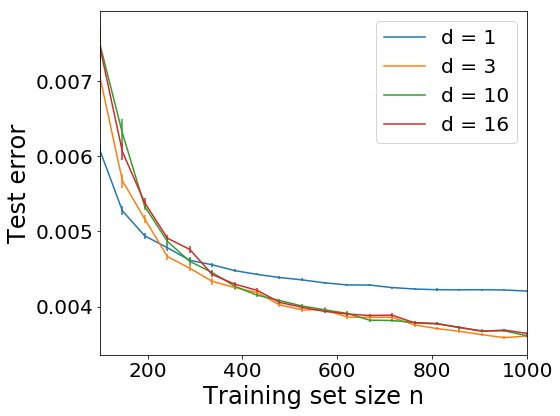

In [26]:
data['err_train'] = data['err_train']
data['err_test']  = data['err_test']

fig, ax = plt.subplots(figsize=(8,6))
for K in [1, 3, 10, d]:
    grp = data[data['deg'] == K].groupby('n_train')
    #errs_mean = grp.mean()
    #errs_std = grp.std() / resample
    sem = lambda x: np.std(x) / resample
    #this_group = errs_mean.join(errs_std)
    tmp = grp.agg({'err_test':['mean', 'sem'], 'err_train':['mean', 'sem'], 'alpha': ['mean', 'sem']})
    tmp.columns = [' '.join(col).strip() for col in tmp.columns.values]
    #df.plot('n_train', 'err_train', ax=ax, kind='line', logy=True, logx=True, style='^-', label=str(K) + " train")
    tmp.plot(y='err_test mean', yerr='err_test sem', ax=ax, kind='line', logy=False, logx=False, style='bo-', label="d = " + str(K))
    #tmp.plot(y='err_train mean', yerr='err_train std', ax=ax, kind='line', logy=True, logx=True, style='rs-', label=str(K) + " train")
    plt.ylabel('Test error')
    #df.boxplot('err_train', by=['n_train', 'deg'], ax=ax)
    plt.xlabel('Training set size n')

plt.savefig('../figures/test_fun_test_error.png')
plt.show()

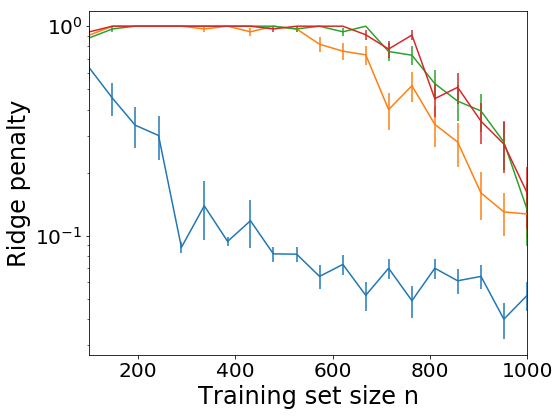

In [28]:
data['err_train'] = data['err_train']
data['err_test']  = data['err_test']

fig, ax = plt.subplots(figsize=(8,6))
for K in [1, 3, 10, d]:
    grp = data[data['deg'] == K].groupby('n_train')
    #errs_mean = grp.mean()
    #errs_std = grp.std() / resample
    sem = lambda x: np.std(x) / resample
    #this_group = errs_mean.join(errs_std)
    tmp = grp.agg({'err_test':['mean', 'sem'], 'err_train':['mean', 'sem'], 'alpha': ['mean', 'sem']})
    tmp.columns = [' '.join(col).strip() for col in tmp.columns.values]
    #df.plot('n_train', 'err_train', ax=ax, kind='line', logy=True, logx=True, style='^-', label=str(K) + " train")
    tmp.plot(y='alpha mean', yerr='alpha sem', ax=ax, kind='line', logy=True, logx=False, style='bo-', label="d = " + str(K))
    #tmp.plot(y='err_train mean', yerr='err_train std', ax=ax, kind='line', logy=True, logx=True, style='rs-', label=str(K) + " train")
    plt.ylabel('Ridge penalty')
    plt.xlabel('Training set size n')
    plt.legend().remove()
    #df.boxplot('err_train', by=['n_train', 'deg'], ax=ax)

plt.savefig('../figures/test_fun_ridge_penalty.png')
plt.show()